In [1]:
#IMPORTING LIBRARIES

import scipy.special as sp # UNUSED?
import numpy as np # NumPy offers comprehensive mathematical functions, random number generators, linear algebra routines, Fourier transforms, and more
import matplotlib.pyplot as plt # Provides a MATLAB-like way of plotting
import pandas as pd # Data analysis and manipulation tool. Used to read in bathymetry data (M77T file), Directions data (excel file), and organises Vmean into a labelled data structure
# M77T data files are created from raw data collected by marine researchers using InfoBank
from scipy.interpolate import CubicSpline as SP # Used to create a spline about the velocity, shape parameter and proability data
from scipy.optimize import minimize,least_squares,Bounds,basinhopping # Optimizing and route finding
from scipy.special import gamma # Gamma function used for weibull distribution
import matplotlib.cm as cm # UNUSED?
from Boruvka_Mod import Graph # imports class graph from Boruvka_Mod python file
import utm # Used to help convert latitude and longitude in bathymetry data to centred eastings and northings
import scipy.interpolate as spline # Used to smooth the bathymetry data
from matplotlib.colors import ListedColormap # UNUSED?
import math # Provides access to the mathematical functions
from time import perf_counter # Returns the float value of time in seconds. Used to record run time for clustering and optimization algorithms
from minmax_kmeans import minsize_kmeans # imports minsize_kmeans function from minmax_kmeans python file
import pulp #Used in the clustering algorithm to generate MPS and LP files
import scipy.signal as signal 
from scipy.signal import savgol_filter
from scipy.interpolate import make_interp_spline, BSpline
from scipy.spatial import ConvexHull

In [2]:
# KEY PARAMETERS USED THROUGHOUT MODEL

a = 350 # minimum distances turbines can be from one another in m.
b = 3000 # distance that turbines have negligible affect on eachother in m. If model changes this value could change

maximumturbinespertree = 10 # number of turbines allowed along a single cable from the substation.
budget = 50000000 # Budget in £ to build the wind farm, accounting for construction costs.
DistanceToShore = 15000 # m #distance of the wind farm from shore
TooCloseShore = 7500 # m # minimum distance the wind farm must be from shore
xCoordOnshoreSub = 0 # x coordinate of the onshore substation (y coordinate is -(DistanceToShore))

USDtoGBP = 1/1.351  
EURtoGBP = 1/1.19

IACableCostperMeter = 409.2*EURtoGBP
ExportCableCostperMeter = 833.625*EURtoGBP

CostperTurbineUSD = 3000000 # USD
CostperTurbine = CostperTurbineUSD*USDtoGBP # GBP

OperatingandMaintenanceCostsperAnnum = 65500 # GBP
LifeTimeTurbineOperatingTime = 20 # years 120000 # hours
MaintenanceCostperTurbine = OperatingandMaintenanceCostsperAnnum*LifeTimeTurbineOperatingTime # in GBP

LandCostperHectare = 17245 # in GBP
LandCostpermSquared = LandCostperHectare/10000 #  in GBP

OffshoreSubstationCostperMW = 104000*EURtoGBP
OnshoreSubstationCostperMW = 87250*EURtoGBP
# Costs  associated with the purchase and installation of electrical substations as well as the buildings required for housing the staff and additional equipment required for the running of the wind farm.

ElectricityCostperkWh = 0.144 # 14.4 pence - £0.144
DiscountRate = 0.07 # 7%

TurbineRating = 2 #2MW

GravityBase = 409000*EURtoGBP*TurbineRating #409000euro/MW
Monopile = 551000*EURtoGBP*TurbineRating
Jacket = 665000*EURtoGBP*TurbineRating
TensionLeg = 1163000*EURtoGBP*TurbineRating

In [3]:
#READING IN BATHYMETRY DATA
data = pd.read_csv("nsea86.m77t", sep='\t') # Reads in all data from file including depth data, lattitude, longitude etc.
mindepth = min(data['CORR_DEPTH']) # Retrieves minimum depth value from data file 'nsea86.m77t'    
print('Shallowest depth:', mindepth, 'm') #Prints out the result for the smallest depth value

Shallowest depth: 17.2 m


In [4]:
###CALCULATES THE INITIAL NUMBER OF TURBINES THE OPTIMISATION SHOULD START WITH.    
maxnodespertree = maximumturbinespertree # As above
minareaperturbine = (1/2)*(math.sqrt(3))*(a**2) # Area per turbine assuming 350m between each turbine
LandCostperTurbine=minareaperturbine*(LandCostpermSquared) # Cost with minimum area
MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(mindepth)**2) - 0.0002*(float(mindepth)) + 0.9459)-CostperTurbine # Uses shallowest depth from before
print('Min depth cost per turbine = £',MinDepthCostPerTurbine) # prints result
MinIACableCostPerTurbine = a*IACableCostperMeter
MinExportCableCost = TooCloseShore*ExportCableCostperMeter # minimum export cable cost with respect to the minimum distance the wind farm must be form shore
MinFoundationCostPerTurbine = GravityBase*TurbineRating

MinCostperTurbTot = CostperTurbine+LandCostperTurbine+MaintenanceCostperTurbine+MinDepthCostPerTurbine+MinIACableCostPerTurbine+MinFoundationCostPerTurbine # Total costs (excluding export cable and fixed costs)
nnturb = (budget-MinExportCableCost)/MinCostperTurbTot 
FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*nnturb*TurbineRating # *2 due to 2MW turbines being used *0.4 for assuming 40% effciency
nturb = (budget-FixedCost-MinExportCableCost)/(MinCostperTurbTot) # Turbines possible with current budget
nturb = math.floor(nturb) # rounds down as cannot have fraction of a turbine
minarea = minareaperturbine*nturb # Overall minimum area considering the amount of turbines
maxarea = nturb*(1/2)*(math.sqrt(3))*(b**2) # Careful this isn't bigger than the entire size of the scaled nsea86 sea floor.

print('Min area per turbine =', minareaperturbine, 'm^2') # prints results
print('Min area =', minarea, 'm^2')
print('Max number of turbines =', nturb)
print('Max area =', maxarea, 'm^2')

Min depth cost per turbine = £ 3615.099925980903
Min area per turbine = 106088.11196359372 m^2
Min area = 848704.8957087498 m^2
Max number of turbines = 8
Max area = 62353829.072479576 m^2


In [5]:
#PRE-OPTIMISATION TURBINE POSITIONING

# places substation at (0,0).
# places 1st turbine at vector (a,0) from substation. a=350m from before
# places 2nd turbine at vector (0.5a,0.5aroot3) from prev. 
# places 3rd turbine at vector (-a,0) from prev
# places 4th turbine at vector (-0.5a,-0.5aroot3) from prev, continues in this spiralling fashion

positionlist = np.empty((nturb+1,2)) # Creates an empty list of size (number of turbines + 1 (since 0 position is substation),2)
turbineposition = np.array([[0,0]]) # Creates [0,0] array for introducing [x,y] coordinates for each turbine
positionlist[0,:] = turbineposition # 

oddcounter = 0
evencounter = 0
i = 0
k = 0

while k<nturb+1: # Loops for number of turbines 
    i += 1
    if (i%2)!= 0: # i is odd
        oddcounter+=1
        for j in range(oddcounter):
            k += 1
            if k == nturb+1:
                break
            if (oddcounter%2)!= 0: #oddcounter is odd
                shift = np.array([[a, 0]])
            else:
                shift = np.array([[-a, 0]])
            turbineposition = np.add(turbineposition, shift)
            positionlist[k,:] = turbineposition
        
    else:
        evencounter+=1
        for j in range(evencounter):
            k += 1
            if k == nturb+1:
                break
            if (evencounter%2)!= 0: #evencounter is odd
                shift = np.array([[0.5*a,0.5*a*math.sqrt(3)]])
            else:
                shift = np.array([[-0.5*a,-0.5*a*math.sqrt(3)]]) 
            turbineposition = np.add(turbineposition, shift)
            positionlist[k,:] = turbineposition
                
print(positionlist) # prints positions data        
print(len(positionlist)) # prints length of positions list (should be the number of turbines + 1 for the subsation)

[[   0.            0.        ]
 [ 350.            0.        ]
 [ 525.          303.10889132]
 [ 175.          303.10889132]
 [-175.          303.10889132]
 [-350.            0.        ]
 [-525.         -303.10889132]
 [-175.         -303.10889132]
 [ 175.         -303.10889132]]
9


In [6]:
# Shoreline implementation

XShoreLine = np.array([np.linspace(min(positionlist[:,0])-6000,max(positionlist[:,0])+6000,1000)]) #Creates x coordinates of shoreline bewtween min and max turbine locations +/- 1000m
YShoreLine = np.array([np.linspace(-DistanceToShore,-DistanceToShore,1000)])
TXShoreLine = np.transpose(XShoreLine) #transpose of x coordinates
TYShoreLine = np.transpose(YShoreLine)
TShoreLine = np.concatenate((TXShoreLine,TYShoreLine),axis=1) # Shoreline (x,y)

In [7]:
# Connects Substatation to shore
# Finds minimum distance between substation and shore


def Substation_To_Shore_Connection(positionlist):
    
    OnshoreSubstation = [xCoordOnshoreSub,-DistanceToShore]
    ExportDistance = np.sqrt(((positionlist[0,0]-OnshoreSubstation[0])**2)+((positionlist[0,1]-OnshoreSubstation[1])**2)) # min Hypotenuse for distances between substation and shore
    
    return OnshoreSubstation,ExportDistance

OnshoreSubstation,ExportDistance = Substation_To_Shore_Connection(positionlist) #Initially Executes algorithm

print(OnshoreSubstation)
print(np.shape(OnshoreSubstation))
print(ExportDistance)

[0, -15000]
(2,)
15000.0


In [8]:
# Pushes wind farm further out if the smallest distance between the shore and center of wind farm is too small
# Only used for the pre-optimised layout
#In terms of keeping it this way there are bounds on (minimize(targetfunction, initial guess, bounds,.....etc.) the optimization function

CloseTurbY = min(positionlist[:,1]) # y coordinate of closest turbine
CloseTurbYindex = np.argmin(positionlist[:,1]) # index from closest turbine on y axis
CloseTurbX = positionlist[CloseTurbYindex,0] # x coordinate of closest turbine on y axis
DistanceToMinTurb = min(np.sqrt((CloseTurbX-TXShoreLine[:,0])**2+(CloseTurbY-TYShoreLine[:,0])**2)) #min distance from shore to closest turbine 
s = 0

if DistanceToMinTurb < TooCloseShore: # if closest turbine is too close to the shore
    for s in range(0,nturb+1): # loops for number of turbines plus the substation
        positionlist[s,1] = positionlist[s,1] + (TooCloseShore-DistanceToMinTurb)
        # Shifts entire wind farm up by the difference to achieve the minimum distance required
    Substation_To_Shore_Connection(positionlist) #Calls function to redo substation to shore connection with new values

(-16303.108891324553, -403.1088913245535)

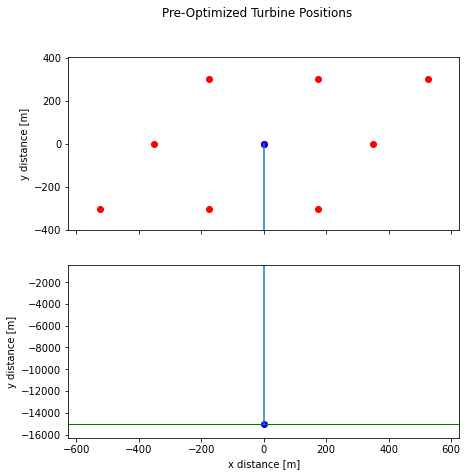

In [9]:
# Display pre-optimized turbine positions before clustering and MST

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)    
ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue') # offshore Substation
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_xlabel('x distance [m]') # x axis label
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

In [10]:
#Function to determine land cost of wind farm using a convex hull
#Calcualtes area of wind farm and onshore substation
#Currently land associated with the export cable has been neglected
def LandAreaCost(positionlist):
    
    radius = 130 #m
    OnshoreSubLand = np.pi*radius**2 #Land area associated with the onshore substation
    
    if len(positionlist)>9: #ConvexHull won't work for less than 2 turbines with the intial set up
        hull = ConvexHull(positionlist) #computes convex hull using the turbine positions
        LandArea = hull.volume + OnshoreSubLand #Calcualtes convex hull area and adds on the onshore substation land area
    else:
        #Unlikely to have wind farms with less than two turbines so just a simple area calculation is computed for this
        LandArea = (max(positionlist[:,0])-min(positionlist[:,0])) * (max(positionlist[:,1])-min(positionlist[:,1]))

    
    LandCost = LandArea*LandCostpermSquared
    
    return LandCost

LandCost = LandAreaCost(positionlist)

print(LandCost)

1097693.6944873042


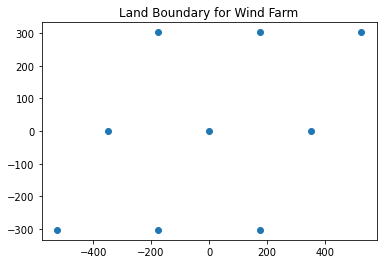

In [11]:
#Visual aid for convex hull plotting

if len(positionlist)>9:
    hull = ConvexHull(positionlist)
    plt.plot(positionlist[:,0], positionlist[:,1], 'o')
    for simplex in hull.simplices:
             plt.plot(positionlist[simplex, 0], positionlist[simplex, 1], 'k-')
else:
    fig, ax = plt.subplots()
    #i = 0
    #for i in range(0,nturb+1):
     #   ax.add_artist(plt.Circle( (positionlist[i,0], positionlist[i,1] ),130 ,fill = False ))
        #ax.add_artist( Drawing_uncolored_circle )
    ax.scatter(positionlist[:,0],positionlist[:,1])

plt.title('Land Boundary for Wind Farm')
plt.show()

C:\Users\Matthew Oxley\Documents\python anaconda\lib\site-packages\pulp\pulp.py:1313: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Function run time: 0.06762170000000012
[[   0    1    2    3    4    5    6    7    8 -100 -100]]


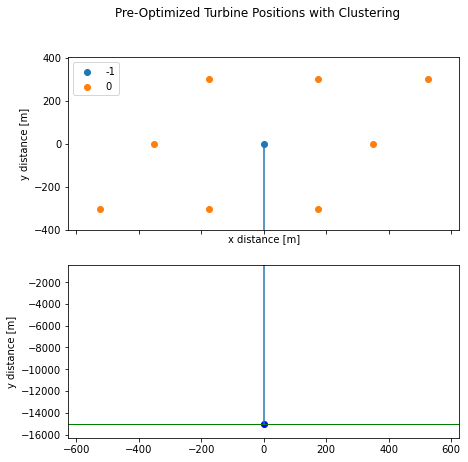

In [12]:
#CLUSTERING ALGORITHM

#Uses an adapted version of kmeans with a cap on the number of points per cluster. Used to radially cluster turbines
#into segments which MST algorithm can then use to determine cabling for a given radial array. Initially unnecessary
#for the initially structured turbine layout as seen above, but increasingly important as turbine layout becomes
#non-uniform through optimisation when the below function is repeatedly called.
# minsize_kmeans imported from external python file

def clustering_algorithm(positionlist,nturb,maxnodespertree):
    k = math.ceil(nturb/maxnodespertree) #number of clusters. math.ceil rounds a number upwards to its nearest integer
    [turbines, centres] = minsize_kmeans(positionlist[1:,:] ,k ,min_size = 1, max_size = maxnodespertree) 
    #turbines exists as an array containing the cluster value for each turbine
    #Assigns each turbine to a cluster. excludes substation, executes external python file, 
    #limits for how many turbines are in each cluster between 1 and max nodes per tree 
    label = np.concatenate((np.array([-1]),turbines)) # Adds -1 (substation label) to the other turbine labels
    u_labels = np.unique(label) 
    # finds unique elements of label. Finds the unique cluster labels 
    # each turbine is assigned a cluster/label and this returns a single label for each cluster
    
    a = 0
    indiceslist = np.empty((k,maxnodespertree), dtype=np.int8) # empty array of no.clusters by max nodes per tree
# indiceslist basically tells us what turbines belong to each cluster
# each row of indiceslist represents a cluster and each point on that row a indidual turbine within that cluster
# Each row starts with a 0 which represents the subsation which belongs to all clusters
# As seen before in the initial layout numbers are assigned starting at 1 which is the turbine (a,0) from the substation
# The numbering then continues in a cyclic motion traveling anticlockwise up until the total number of turbines
    
    for i in range(k): # loops for number of clusters
        indices = [i for i, x in enumerate(label) if x == a] # enumerate exists as a counter in the loop (starts at x=a=0)

        if len(indices) < maxnodespertree:
            noofemptys = maxnodespertree - len(indices)
            for l in range(noofemptys): # For the empty spaces in the matrix replaces these with -100 as fillers
                indices.append(int(-100))
    
        indiceslist[i,:] = (indices)
        a += 1
    
    arr = np.zeros((k,1),dtype=np.int8)   # zero array of number of clusters by 1 (Substation array)
    indiceslist = np.concatenate((arr,indiceslist),axis=1) # Adds substation zero array to turbine cluster matrix
    return indiceslist,u_labels,label

t1_start = perf_counter() # Starts timer
indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree) #Executes clustering algorithm
t1_stop = perf_counter() # Ends timer
print('Function run time:', t1_stop-t1_start) # Prints algorithm run time

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions with Clustering')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
for i in u_labels: # loops for number of turbines
    ax1.scatter(positionlist[label == i , 0] , positionlist[label == i, 1] , label = i)
ax1.legend() # prints legend
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_xlabel('x distance [m]') # x axis label
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

print(indiceslist)

In [13]:
#CREATES INPUT NEEDED FOR MST ONCE CLUSTERS ARE DEFINED.

#distance_global - distances of each turbine with respect to the substation and each other h=sqrt(x^2+y^2)
#e.g. row 0 would be each turbines distance with respect to the substation
# and row 4 would be each turbines distance with respect to the 4th turbine as found in the position list
# distance_globl[i,i] = 1e10 since this is the distance of each turbine with respect to itself
#angle_global - angle of each turbine with respect to the substation and each other arctan(y/x)
#distance and angle then do something similar but considering the cluster formations as well

def geom_analysis(positionlist,indiceslist):
    
    #Arrays for pairwise distances and angles
    #Angle 0: x directıon. Angle pi/2: y directıon
    distance = [None] * math.ceil(nturb/maxnodespertree) # null array with size based on number of clusters
    angle = [None] * math.ceil(nturb/maxnodespertree) 
    distance_global = np.zeros((nturb,nturb)) #zero array nturb by nturb. This will be for storing the distance between each pair of turbines for cabling
    angle_global = np.zeros((nturb,nturb)) # Like above this will be for storing the angle data between each pair of turbines for cabling
    coords = positionlist[1:,:] # Coordinates of each turbine

    for i in range(0,nturb): # loops for number of turbines
        distance_global[i,:]=np.sqrt(np.square(coords[i,0]-coords[:,0])+np.square(coords[i,1]-coords[:,1])) # Pythagoras for hypotenuse
        angle_global[i,:]=np.arctan2(coords[:,1]-coords[i,1],coords[:,0]-coords[i,0]) #Pythagoras for angle
        distance_global[i,i]=1e10
        #Rotate angles so that north=0 and convert to degrees
    angle_global=-np.rad2deg(angle_global)+270
    
    for x in range(0,math.ceil(nturb/maxnodespertree)): # loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1) # Everything except the -100 ones which were denoted earlier to show that there is no turbine at that index
        distance[x]=np.zeros((nturbintree,nturbintree))
        angle[x]=np.zeros((nturbintree,nturbintree))
    
        for i in range(0,nturbintree):
            for j in range(0,nturbintree):
                distance[x][i,j] = np.sqrt(np.square(positionlist[(indiceslist[x,i]),0]-positionlist[(indiceslist[x,j]),0]) + np.square(positionlist[(indiceslist[x,i]),1]-positionlist[(indiceslist[x,j]),1]))
                angle[x][i,j]=np.arctan2(positionlist[(indiceslist[x,j]),1]-positionlist[(indiceslist[x,i]),1],positionlist[(indiceslist[x,j]),0]-positionlist[(indiceslist[x,i]),0])
                distance[x][i,i]=1e10
        
        #Rotate angles so that north=0 and convert to degrees
        angle[x]=-np.rad2deg(angle[x])+270
      
    return distance,angle,distance_global,angle_global

In [14]:
# DETERMINES MINIMUM LENGTH OF CABLING REQUIRED TO CREATE COMPLETE CABLING NETWORK SUCH THAT ALL TURINES ARE CONNECTED
# IN ACCORDANCE WITH USER'S CONDITIONS.

def Minimum_Spanning_Tree(distance,indiceslist):

    MSTweight = [None] * math.ceil(nturb/maxnodespertree) # null array with sized based on number of clusters
   
    for x in range(0,math.ceil(nturb/maxnodespertree)): #loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1)
        g=Graph(nturbintree) #Graph is part of the external python script titled Boruvka_Mod
        
        for i in range(0,nturbintree):
            for j in range(i+1,nturbintree):
                g.addEdge(i,j ,(distance[x][i,j]*1000))
           
        MSTweight[x]=g.boruvkaMST()

    return MSTweight

Each tree weight tree 1 2800000.0
MST total weight 2800000.0 m


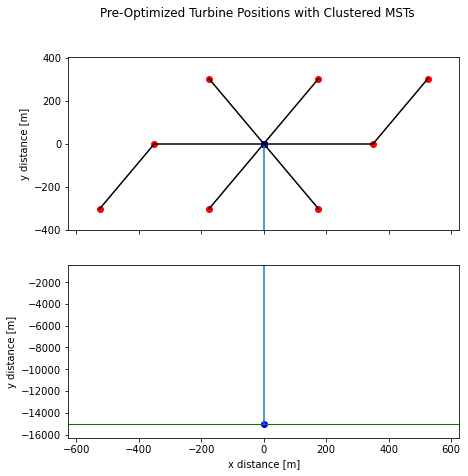

In [15]:
#PLOTTING PRE-OPTIMISED MST

# the Boruvka_mod code requires graphs with vertices 0....n, which is provided by the index value on indices list.
# When this is plotted, the values within the correct indiceslist row are then used to reference the index within
# positionlist to be plotted.

#

MSTweight=Minimum_Spanning_Tree(geom_analysis(positionlist, indiceslist)[0],indiceslist)

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions with Clustered MSTs')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_xlabel('x distance [m]') # x axis label
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

links = [None] * math.ceil(nturb/maxnodespertree)
MSTWeightSum = 0 #MST weight is simply the total length of cabling used

for a in range(0,math.ceil(nturb/maxnodespertree)):
    MSTWeightSum += MSTweight[a][0]
    print('Each tree weight', 'tree',a+1 ,MSTweight[a][0])
    links[a] = MSTweight[a][1]
    
    for b in links[a]:
        u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
        v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
        ax1.plot(u,v, c='black')
        ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue')
        
print('MST total weight', MSTWeightSum, 'm')

In [16]:
#DISPLAYS RAW BATHYMETRY DATA

print(data) # Prints out bathymetry data - Read in using pandas in previous section

      SURVEY_ID  TIMEZONE      DATE     TIME       LAT      LON  POS_TYPE  \
0        NSEA86         0  19860424  149.733  54.50260  4.42565       NaN   
1        NSEA86         0  19860424  150.700  54.50254  4.42011       NaN   
2        NSEA86         0  19860424  151.717  54.50247  4.41424       NaN   
3        NSEA86         0  19860424  152.683  54.50240  4.40861       NaN   
4        NSEA86         0  19860424  153.667  54.50234  4.40282       NaN   
...         ...       ...       ...      ...       ...      ...       ...   
18132    NSEA86         0  19860513  555.800  52.81589  4.07220       NaN   
18133    NSEA86         0  19860513  556.900  52.81516  4.07883       NaN   
18134    NSEA86         0  19860513  557.733  52.81459  4.08396       NaN   
18135    NSEA86         0  19860513  558.700  52.81396  4.08972       NaN   
18136    NSEA86         0  19860513  559.750  52.81325  4.09609       NaN   

       NAV_QUALCO  BAT_TTIME  CORR_DEPTH  ...  MAG_RESSEN  MAG_DICORR  \
0 

In [17]:
#CONVERTS LATITUDE AND LONGITUDE IN BATHYMETRY DATA TO CENTERED EASTINGS AND NORTHINGS

data['easting'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[0], axis=1) #Converts lon/lat to easting and adds this onto the 'data' file
data['northing'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[1], axis=1) #Converts lon/lat to northing and adds this onto the 'data' file

zero_east = min(data['easting']) + (max(data['easting']) - min(data['easting']))/2 +30000 # Determines centre of bathymrtry data in easting direction (+30,000 is simply to get a more interesting result from the current bathymetry data)
zero_north = min(data['northing']) + (max(data['northing']) - min(data['northing']))/2 # Determines centre of bathymetry data in northing direction   

data['centered_easting'] = data['easting'] - zero_east # Centres the data about (0,0) and adds this onto the 'data' file
data['centered_northing'] = data['northing'] - zero_north # Centres the data about (0,0) and adds this onto the 'data' file

print(data) 

      SURVEY_ID  TIMEZONE      DATE     TIME       LAT      LON  POS_TYPE  \
0        NSEA86         0  19860424  149.733  54.50260  4.42565       NaN   
1        NSEA86         0  19860424  150.700  54.50254  4.42011       NaN   
2        NSEA86         0  19860424  151.717  54.50247  4.41424       NaN   
3        NSEA86         0  19860424  152.683  54.50240  4.40861       NaN   
4        NSEA86         0  19860424  153.667  54.50234  4.40282       NaN   
...         ...       ...       ...      ...       ...      ...       ...   
18132    NSEA86         0  19860513  555.800  52.81589  4.07220       NaN   
18133    NSEA86         0  19860513  556.900  52.81516  4.07883       NaN   
18134    NSEA86         0  19860513  557.733  52.81459  4.08396       NaN   
18135    NSEA86         0  19860513  558.700  52.81396  4.08972       NaN   
18136    NSEA86         0  19860513  559.750  52.81325  4.09609       NaN   

       NAV_QUALCO  BAT_TTIME  CORR_DEPTH  ...   GRA_OBS  EOTVOS  FREEAIR  \

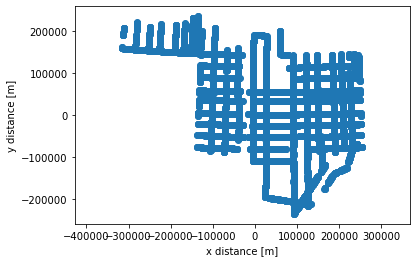

In [18]:
#PLOTS CENTERED BATHYMETRY DATA

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

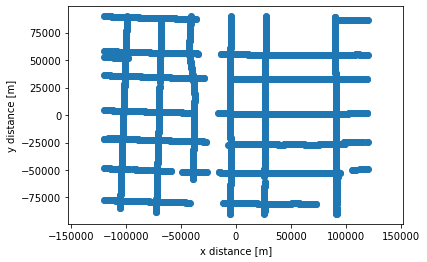

In [19]:
# SAMPLING AND PLOTTING CENTRAL BATHYMETRY DATA
# Takes sample between +/-120000 in easting direction, +/-90000 in the northing direction, and +/-1000 for the depth values

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data = data[(data['centered_easting'] >=-120000) & (data['centered_easting'] <= 120000) & (data['centered_northing']>=-90000) & (data['centered_northing']<= 90000) & (data['CORR_DEPTH']<=1000) & (data['CORR_DEPTH']>=-1000)]
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

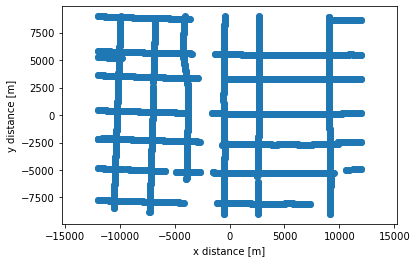

In [20]:
#FURTHER BATHYMETRY DATA PROCESSING
#Further decreases the area considered to be more applicable to the size of the wind farm (Sample from before divided by 10 in northing and easting directions)

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data['centered_easting'] = data['centered_easting']/10
data['centered_northing'] = data['centered_northing']/10
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

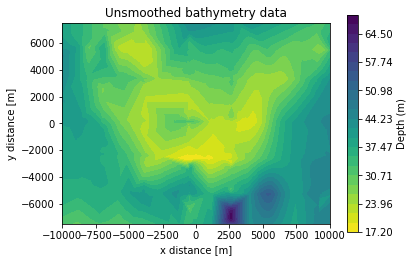

In [21]:
#UNSMOOTHED BATHYMETRY DATA CONTOUR PLOTTING

fig, ax = plt.subplots()
plt.xlim([-10000, 10000]) # x Limits of plot between +/-10000
plt.ylim([-7500, 7500]) # y Limits of plot between +/-7500
ax.set_aspect(aspect=1) # Sets the aspect of the axis scaling, i.e. the ratio of y-unit to x-unit.
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')

maxdepth = max(data['CORR_DEPTH'])
levels = np.linspace(mindepth,maxdepth,24) # Creates 24 even spaces or levels between the min and max depth

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], levels=levels, cmap = 'viridis_r') # (x,y,colour bar factor,level values,colour scale)
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Unsmoothed bathymetry data');

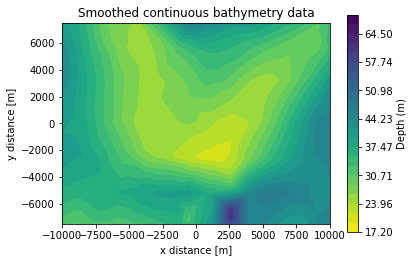

In [22]:
#SMOOTHING BATHYMETRY DATA

smooth = spline.SmoothBivariateSpline(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], s = 25000)

fig, ax = plt.subplots()
plt.xlim([-10000, 10000])
plt.ylim([-7500, 7500])
ax.set_aspect(aspect=1)
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
levels = np.linspace(mindepth,maxdepth,24)

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Smoothed continuous bathymetry data');

In [23]:
# DETERMINING DEPTH AND ASSOCIATED COST FOR EACH TURBINE

def depthvalues(positionlist):
    DepthPerTurbine = [None] * (len(positionlist)-1) # none defines a null/no value. Get a null list the size of the np. turbines
    DepthCostPerTurbine = [None] * (len(positionlist)-1) # Get a null list the size of the number of turbines
    DepthCostAllTurbines = 0 # Assigns initial value to variable

    for i in range(0,len(positionlist)-1): # loops for amount of turbines
        DepthPerTurbine[i] = spline.SmoothBivariateSpline.ev(smooth, positionlist[i+1,0], positionlist[i+1,1]) # Acquires depth assigned to each turbines position (x,y)
        DepthCostPerTurbine[i] = MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(DepthPerTurbine[i])**2) - 0.0002*(float(DepthPerTurbine[i])) + 0.9459)-CostperTurbine #Formula for depth cost
        DepthCostAllTurbines += DepthCostPerTurbine[i] # Sums up all turbines depth costs
        
    mindepth=float(min(DepthPerTurbine))
    maxdepth=float(max(DepthPerTurbine))
    return DepthCostAllTurbines, mindepth, maxdepth # returns respective values to user

depthvalues(positionlist)

(1316501.2652558908, 25.03640356475352, 26.577296604068042)

In [24]:
#SETTING MODEL PARAMETERS

v0=8.0  #Incoming wind speed
nwind = 33
wind=np.arange(254,287)

#b=np.array((1,5,1000))
#b=np.array(( 1.40002561e-01,   8.51478121e+00,   2.62606729e+03))

# 3 model parameters below:

# 0th: how much power the turbine removes at the centre of the peak of the power distribution.
# 1st: how wide the angle of effect is. UNITS: degrees
# 2nd: up to how far back the effect takes place (approx. 2.6km) UNITS: [m]

model=np.array((1.39998719e-01, 8.51483871e+00, 2.62613638e+03))

ws=2.0 #weibull scale factor
wei_gamma=gamma(1.+1./ws)

Pr = 2*10**6 #Rated Power for Horns Rev 1 Turbines. Max power output [Watts]
Vc = 4.0 #Cut-in Velocity. Starts producing energy at wind speed of 4m/s [m/s]
Vr = 15.0 #Rated Velocity. Starts producing max energy at 15m/s
Vf = 25.0 #Cut-off Velocity. Turbines cut out at wind speeds of 25m/s to prevent damage to the turbines.
k = 2.0 #Weibull shape parameter
(Pr,Vc,Vr,k)

#interpolation parameters
dvel=1.5 #[m/s]
dang=5. #[degrees]

In [25]:
#DETERMINING WIND DIRECTION AND VELOCITY AT HORNS REV 1

v=np.loadtxt('hornsrev_data_all.txt') # assigns data to variable v.
vxref=v[:,3] # (INDEXING STARTS FROM 0). Third column of data is velocity of wind in x direction.
vyref=v[:,4] # (INDEXING STARTS FROM 0). Fourth column of data is velocity of wind in y direction.
angles=v[:,0] # Zeroth column of data is wind angle.
vmean=np.sqrt(np.square(vxref)+np.square(vyref)) # Uses pythagoras to find the wind magnitude + direction for each location.

vmean=pd.DataFrame(vmean) # organises vmean into labelled data structure
vref=pd.DataFrame()

vmean['angle']=angles # add another column to vmean (angle)
vref=vref.append(vmean) # add empty pandas data frame

vref=vref.groupby('angle')
vref.groups
vref.describe()
vref.get_group(260).iat[50,0] # data manipulation to group by angle etc.

6.512913707119303

In [26]:
#Arrays for pairwise distances and angles
#Angle 0: x direction. Angle pi/2: y directıon

# calculates distance and angle between each pair of turbines:

distance=np.zeros((nturb,nturb)) # 2x2 matrix of distances between turbines i and j where distance i-i and distance j-j = 0
# as they're distances to themselves: i-i i-j
                                 #    j-i j-j

angle=np.zeros((nturb,nturb)) # same as above but for angles between turbines.

for i in range(0,nturb):
   
    # 80x80 matrices as there's 80 turbines at Horns Rev 1.
    # squares y distance and x distance then sqrt to find overall distance between 2 turbines.
    distance[i,:]=np.sqrt(np.square(positionlist[i+1,0]-positionlist[1:,0])+np.square(positionlist[i+1,1]-positionlist[1:,1]))
    # same as above using arctan2 whilst giving correct quadrant (between 2 turbines).
    angle[i,:]=np.arctan2(positionlist[1:,1]-positionlist[i+1,1],positionlist[1:,0]-positionlist[i+1,0])
# Rotate angles so that north=0 and convert to degrees (and clockwise instead of anticlockwise)
angle=-np.rad2deg(angle)+270

# Rotating angles to wind direction
windangle=5 # degrees
rotangles=np.mod(angle-windangle+180,360)-180

In [27]:
# IMPORTING WIND DIRECTION DATA

#meteorological data where north = 0 degrees)
directiondata = pd.read_csv ('Directiondata.csv')
print (directiondata)
# velocity is the mean velocity with which wind from this direction blows
# c determines how wide the distribution is
# frequency/100 determines how often the wind is blowing at this angle

    Angle  Velocity     c  frequency
0       0      8.89  2.09       4.82
1      30      9.27  2.13       4.06
2      60      8.23  2.29       3.59
3      90      9.78  2.30       5.27
4     120     11.64  2.67       9.12
5     150     11.03  2.45       6.97
6     180     11.50  2.51       9.17
7     210     11.92  2.40      11.84
8     240     11.49  2.35      12.41
9     270     11.08  2.27      11.34
10    300     11.34  2.24      11.70
11    330     10.79  2.19       9.69
12    360      8.89  2.09       4.82


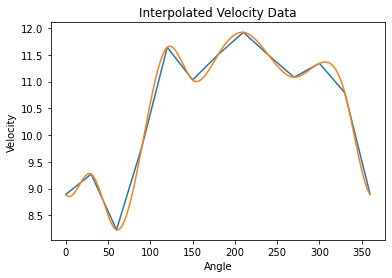

In [28]:
# interpolate 'velocity'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['Velocity']
wbvel = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360,0.10)
plt.plot(x,y, label='Line')
plt.plot(xs, wbvel(xs), label="Interpolated line ")
plt.title('Interpolated Velocity Data')
plt.xlabel('Angle')
plt.ylabel('Velocity')
plt.show()
# blue lines shows linear interpolation, orange shows smooth interpolation including across the
# periodic boundary.

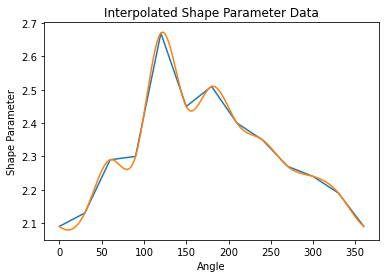

In [29]:
#interpolate 'c'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['c']
wbshape = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, wbshape(xs), label="S")
plt.title('Interpolated Shape Parameter Data')
plt.xlabel('Angle')
plt.ylabel('Shape Parameter')
plt.show()

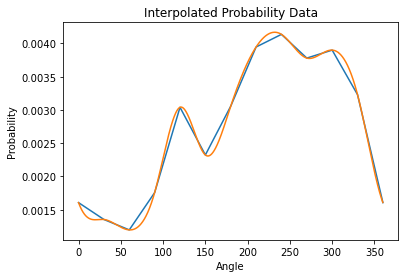

In [30]:
#interpolate 'frequency'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['frequency']/(100.*30.) #Data is in percent per 30 degrees, changing to probability per degree


windfreq = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, windfreq(xs), label="S")
plt.title('Interpolated Probability Data')
plt.xlabel('Angle')
plt.ylabel('Probability')
plt.show()
# plot shows wind direction is predominantly 200-320deg.

In [31]:
# Simple Attenuation fn
# Determines how much wind there is AFTER a turbine.
def att(dist, ang, model): 
        # 'Model' parameters are defined in 2ND CELL.

    # angular part
    angular=np.where(2.*model[1]*np.abs(ang)<np.pi,np.square(np.cos(model[1]*ang)),0.)
    # angular = np.cos(model[1]*ang WHEN 2.*model[1]*np.abs(ang) is less than pi, else angular = 0.
    
    # radial part (distance) (Gaussian Function)
    radial=np.exp(-np.square(dist/model[2])) # decreasing exponential of square, scaled by 2nd parameter
    penalty=np.exp(-np.square(dist/200))
    #penalty = 0
    return 1.0-1*model[0]*angular*radial-2*model[0]*penalty # OUTCOME

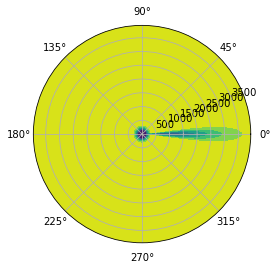

0.580003843


In [32]:
azimuths = np.radians(np.linspace(0, 360, 360)) # angles theta from 0 to 360 degress in 1 degree increments. Grid
zeniths = np.arange(0, 4000, 50) # distance from 0 to 4000 broken up into increments of 50.

r, theta = np.meshgrid(zeniths, azimuths)
values = att(r,np.mod(theta+np.pi,np.pi*2)-np.pi,model) # gets angles from -pi to pi, not from 0 to 2pi.

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta, r, np.maximum(values,0.85*np.ones(np.shape(values))))

plt.show()
print(np.min(values))

## Cell description:
# Polar plot is for 1 turbine, blue area shows where wind speed is affected. (Numbers label distance from turbine).
# Across the curve the distribution is the hump of cosine^2 function.
# Radially the distribution shown is Gaussian.
# Wake is currently too narrow close to the turbine as it treats the turbine as a point rather than accommodating
# for the blades' diameter.

In [33]:
# # isn't useful for continuing code, just rotates the windfarm.
# def rotate(angle,coords):
#     angle = np.pi*angle/180.
#     rotcoordx = []
#     rotcoordy = []
#     for coord in coords:
#         rotcoordx+=[coord[0]*np.cos(angle)-coord[1]*np.sin(angle)]
#         rotcoordy+=[coord[0]*np.sin(angle)+coord[1]*np.cos(angle)]
#     rotcoords=[rotcoordx,rotcoordy]
#     rotcoords=np.array(rotcoords).T   
#     return rotcoords 
# #print rotate(254,coords)[:,0]
# plt.scatter(rotate(0,coords)[:,0],rotate(0,coords)[:,1])

In [34]:
# returning total deviation between model and training set (between CFD data and the attenuation model)
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation(b):
    total_att=np.ones((nturb,nwind))
    deviation=0
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]*att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,b)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            deviation=deviation+np.square(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return deviation

In [35]:
# returning deviation for each turbine.
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation_sq(model):
    total_att=np.ones((nturb,nwind))
    dev_vec=np.zeros((nturb*nwind))
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,model)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            dev_vec[nturb*k+j]=(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return dev_vec

In [36]:
# USEFUL OUTPUT USED IN TARGET FN
# Calculates the % of wind that arrives at a turbine for a certain angle.
# Starts with assumption that there's zero wake so all turbines get full wind.
#talked about
#Total att
def windspeedreduction(distance,angle,direction,model): # vectors
    ndir=np.size(direction)
    total_att=np.ones((nturb,ndir)) # as many rows as there are turbines, as many columns as there are wind directions.
 #   power_vec=np.zeros((nturb,ndir))
    for j in range(0,nturb):
        for i in range(0,nturb):
            if (i!=j):
                # compounding wind speed reductions
                total_att[j,:] = total_att[j,:]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-direction[:])+np.pi,np.pi*2)-np.pi,model)
  #      power_vec[j,:]=(v0*total_att[j,:])**3
    return total_att # matrix output that's needed. n turbine rows, n direction columns.
                     # Tells how much of 100% of wind arrives at a certain turbine from a certain direction.

In [37]:
# USEFUL OUTPUT USED IN TARGET FN
# Calculates the power produced by turbines when it sees a certain wind speed at a certain angle. 3D matrix
def power(wsr,v): # wind speed reduction, velocity
    nvel=np.size(v)
    nangle=np.size(wsr,1)
    power_vec=np.zeros((nturb,nangle,nvel))
    power_vec=POvec(np.outer(wsr,v)).reshape(nturb,nangle,nvel) # np.outer takes every wsr element and individually multiplies it with every element of v.
    return power_vec

In [38]:
#GIVES PROBABILITY OF WIND SPEED V AT A GIVEN ANGLE
def windspeedprobability(angles,v,d_angle,d_vel):
    nvel=np.size(v) 
    nangle=np.size(angles)
    wsprob=np.zeros((nangle,nvel))
    for i in range(angles.shape[0]):
        # Get Weibull parameters for angle and evaluate probability
        wsprob[i,:]=(wei(v[:],wbvel(angles[i]),wbshape(angles[i])))*windfreq(angles[i])*d_angle*d_vel
    return wsprob

In [39]:
# DEFINES WEIBULL DISTRIBUTION (shows the probability of any given wind speed occuring).

def wei(x,n,k): # convention to have in this order, scale parameter comes first (x) 
    u=n/gamma(1+1/k) #scaled wind speed
    return (k / u) * (x / u)**(k - 1) * np.exp(-(x / u)**k)
# k = Weibull shape parameter
# n = scale parameter
# x= value we are valuating

In [40]:
def wind_dist(v,vm):
    return wei(v,vm,k)

In [41]:
wind_dist(1.0,v0)

0.024244336764100854

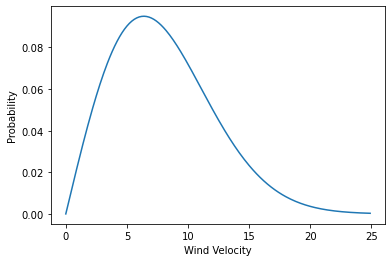

In [42]:
# PLOTS WEIBULL DISTRIBUTION

x=np.arange(0,25,0.1)
y=wind_dist(x,v0)

plt.xlabel('Wind Velocity')
plt.ylabel('Probability')
plt.plot(x,y)

In [43]:
 velocities=np.arange(Vc,Vf,dvel) # 1D array ranging from Vc to Vf in dvel intervals. 4 to 25 in steps of 1.5
angles=np.arange(0,360,dang) # 0 to 360 with intervals of dang.
wsp=windspeedprobability(angles,velocities,dang,dvel) # tells probability of getting wind from a certain direction with a certain velocity.
# sum of all numbers would add up to 1.
print(wsp,np.shape(wsp),np.sum(wsp)) # wsp array, shape of wsp (rows,columns), sum of wsp elements
print(np.shape(velocities)) # shape of velocities array (rows, columns)
#plt.plot(x,y)

[[7.95303494e-04 9.80036676e-04 1.05789271e-03 ... 6.39190809e-05
  3.40253887e-05 1.70630457e-05]
 [7.34767202e-04 9.01764403e-04 9.69915308e-04 ... 5.75583274e-05
  3.06371248e-05 1.53701909e-05]
 [6.87320078e-04 8.44491359e-04 9.10294073e-04 ... 5.77144043e-05
  3.11157981e-05 1.58295009e-05]
 ...
 [9.80182139e-04 1.25683306e-03 1.41621103e-03 ... 1.55577912e-04
  9.05953796e-05 4.99151675e-05]
 [9.27369324e-04 1.17045619e-03 1.29626789e-03 ... 1.10756647e-04
  6.20462178e-05 3.28196113e-05]
 [8.63068120e-04 1.07416013e-03 1.17166708e-03 ... 8.08008629e-05
  4.38237311e-05 2.24068824e-05]] (72, 14) 0.9458659589195532
(14,)


In [44]:
# CALCULATES THE POWER CURVE OF A TURBINE

# Plots the power curve of a turbine.
# No power output from 0-4m/s, then cubic rise up to 15m/s and stays
# constant until cut-off velocity of 25m/s.

#cubic Based Power output
a=Pr/(Vr**3-Vc**3)
b=Vc**3/(Vr**3-Vc**3)

def q(v): # q is power output

    if (v<Vc): # below cut in velocity power is 0.
        q=0
    elif (v<Vr):
        q=a*v**3-b*Pr # cubic power output between cut in and max.
    elif (v<Vf):
        q=Pr # max power between max and cut off velocity.
    else: 
        q=0 # no power above cut off velocity.
    return q

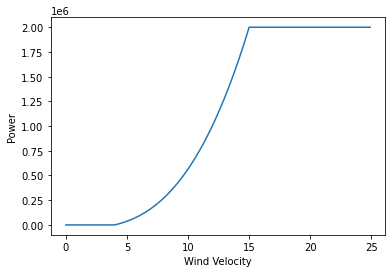

In [45]:
#PLOTS TURBINE POWER CURVE

x=np.arange(0,25,0.1)
POvec=np.vectorize(q) # vectorises power output function q (from cell above).
y=POvec(x)

plt.xlabel('Wind Velocity')
plt.ylabel('Power')
plt.plot(x,y)

In [46]:
wsr=windspeedreduction(distance,angle,angles,model)
powout=power(wsr,velocities)

In [47]:
# EXPECTED TURBINE OUTPUT (Watts) for the given wind distribution and positions.
# Can be seen that top left (NW) produces most energy for Horns Rev 1 Wind Farm.

# EXPECTED POWER FROM WIND FARM CALCULATIONS
# multiply the power that you'd get for each wind angle and speed condition by the probability of this occuring, for all angles and speed
# values and sum to find the expected power.
# Sum up this value for all turbines to find total wind farm expected power output.
output=np.zeros((nturb)) 
output=np.tensordot(powout,wsp,2)
print(output,np.shape(output),np.sum(output))
# last output is total power output in Watts.

[756970.79422734 770088.76969728 757967.83769241 783763.90762771
 777147.58480853 810792.4458581  781045.31463642 789635.60731146] (8,) 6227412.261859251


In [48]:
# TURBINE OUTPUT (Watts) WITH NO INTERFERENCE

#Reference output:
# Same calculations as cell above except each turbine sees the full amount of wind every time
# (i.e. no wind reduction from other turbines).
refpowout=power(np.ones((nturb,np.size(angles))),velocities)
refoutput=np.zeros((nturb))
refoutput=np.tensordot(refpowout,wsp,axes=2)
print(refoutput,np.shape(refoutput),np.sum(refoutput))

# last output is total power output in Watts.

[867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078] (8,) 6937285.280646257


In [49]:
# # assigns smaller interpolation intervals to dvel and dang to compare to coarser interpolations.
# dvel=0.1
# dang=0.1
# velocities=np.arange(Vc,Vf+dvel,dvel)
# angles=np.arange(0,360,dang)
# wsp=windspeedprobability(angles,velocities,dang,dvel)
# wsr=windspeedreduction(distance,angle,angles,model)
# powout=power(wsr,velocities)
# output=np.zeros((nturb)) 
# output=np.tensordot(powout,wsp,2)
# print (dvel,dang,np.sum(output))
# fineout=output

In [50]:
# # Calculates RMS error from changing interpolation value.
# velarray=np.array([1.5])
# angarray=np.array([5])
# rmserror=np.zeros((np.size(velarray),np.size(angarray)))
# i=0
# for dvel in velarray:
#     j=0
#     for dang in angarray:
#         velocities=np.arange(Vc,Vf+dvel,dvel)
#         angles=np.arange(0,360,dang)
#         wsp=windspeedprobability(angles,velocities,dang,dvel)
#         wsr=windspeedreduction(distance,angle,angles,model)
#         powout=power(wsr,velocities)
#         output=np.zeros((nturb)) 
#         output=np.tensordot(powout,wsp,2)
#         rmserror[i,j]=np.sqrt(np.sum(np.square(output-fineout))/np.size(output))
#         print (dvel,dang,np.sum(output),rmserror[i,j])
#         j+=1
#     i+=1
# print(rmserror)

In [51]:
distance,angle,distance_global, angle_global = geom_analysis(positionlist,indiceslist)
wsr=windspeedreduction(distance_global,angle_global,angles,model)
powout=power(wsr,velocities) # total output power
output=np.tensordot(powout,wsp,axes=2)

In [52]:
def foundationDepthCost(foundation,DepthPerTurbine):
    
    FoundationCost = foundation*(0.0002*(float(DepthPerTurbine)**2) - 0.0002*(float(DepthPerTurbine)) + 0.9459)
    
    return FoundationCost

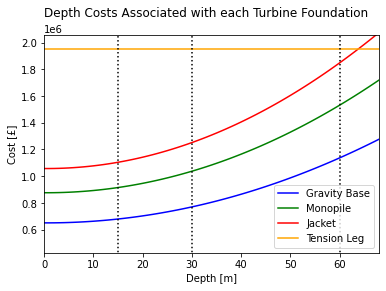

In [53]:
# Plots depth functions for each individual turbine foundation type

Depthx = range(0,math.ceil((max(data['CORR_DEPTH']))),1)
GBCost = [None] * len(Depthx)
MPCost = [None] * len(Depthx)
JCost = [None] * len(Depthx)
TLCost = [None] * len(Depthx)
Depth = 0

for i in Depthx:
    GBCost[i] = foundationDepthCost(GravityBase,Depth)
    MPCost[i] = foundationDepthCost(Monopile,Depth)
    JCost[i] = foundationDepthCost(Jacket,Depth)
    TLCost[i] = TensionLeg
    Depth += 1
    
fig, ax = plt.subplots()
fig.suptitle('Depth Costs Associated with each Turbine Foundation')

x1 = np.linspace(15,15,100)
x2 = np.linspace(30,30,100)
x3 = np.linspace(60,60,100)
y = np.linspace(0,TensionLeg+500000,100)

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH']-1)))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx,GBCost,'blue')
ax.plot(Depthx,MPCost,'green')
ax.plot(Depthx,JCost,'red')
ax.plot(Depthx,TLCost,'orange')
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')
plt.legend(['Gravity Base','Monopile','Jacket','Tension Leg'])

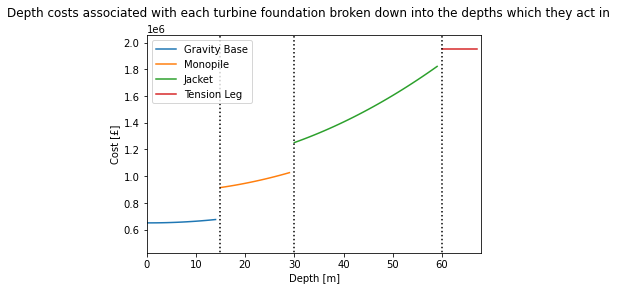

In [54]:
# Plots depth functions for each individual turbine foundation type but only considers the depths for which the foundation will act in

GBCost2 = GBCost[Depthx[0]:Depthx[15]]
MPCost2 = MPCost[Depthx[15]:Depthx[30]]
JCost2 = JCost[Depthx[30]:Depthx[60]]
TLCost2 = TLCost[Depthx[60]:max(Depthx)]

fig, ax = plt.subplots()
fig.suptitle('Depth costs associated with each turbine foundation broken down into the depths which they act in')

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH']-1)))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx[0:15],GBCost2)
ax.plot(Depthx[15:30],MPCost2)
ax.plot(Depthx[30:60],JCost2)
ax.plot(Depthx[60:max(Depthx)],TLCost2)
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')
plt.legend(['Gravity Base','Monopile','Jacket','Tension Leg'])

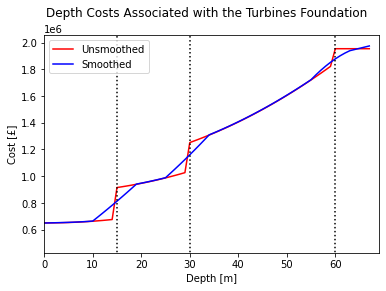

In [55]:
# Combines all the indivdual depths costs over there used depths into one plot and smooths the data

GBMPJTL = GBCost2+MPCost2+JCost2+TLCost2

fig, ax = plt.subplots()
fig.suptitle('Depth Costs Associated with the Turbines Foundation')

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH'])))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx[0:max(Depthx)],GBMPJTL,color='r')
smoothed_2dg = savgol_filter(GBMPJTL, window_length = 9, polyorder = 1)
ax.plot(Depthx[0:max(Depthx)], smoothed_2dg, color='b')
plt.legend(['Unsmoothed','Smoothed'])
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')

In [56]:
def foundations(positionlist):
    
    DepthPerTurbine = [None] * (len(positionlist)-1) # none defines a null/no value. Get a null list the size of the np. turbines
    FoundationCost = [None] * (len(positionlist)-1) # Get a null list the size of the number of turbines
    FoundationCostTotal = 0 # Assigns initial value to variable
    
    for i in range(0,len(positionlist)-1): # loops for amount of turbines
        DepthPerTurbine[i] = spline.SmoothBivariateSpline.ev(smooth, positionlist[i+1,0], positionlist[i+1,1])
        
        FoundationCost[i] = np.interp(DepthPerTurbine[i],Depthx[0:max(Depthx)],smoothed_2dg)

        FoundationCostTotal += FoundationCost[i]
        
    return FoundationCostTotal

FoundationCostTotal = foundations(positionlist)

In [57]:
# Function for calculated payback time, discounted payback time, Net Present Value, and Profitability Index

def Payback(TPO,TotalCost,positionlist):
    
    nturb=np.size(positionlist,0)-1 # -1 due to the substation at positonlist[0,:]
    
    CashFlowYearly = (ElectricityCostperkWh*24*365*(TPO/1000))-(OperatingandMaintenanceCostsperAnnum*nturb) # Calculates the yaerly cash flow for the windfarm
    PayBackTime = TotalCost/CashFlowYearly # calculates payback time in years
    DiscountedPayBackTime = (np.log(1/(1-((TotalCost*DiscountRate)/CashFlowYearly))))/np.log(1+DiscountRate) #Calculates payback time but takes into account the time value of money
    
    l=0
    NPV = 0
    
    for l in range(LifeTimeTurbineOperatingTime):
        l+=1
        NPV = NPV + (CashFlowYearly)/((1+DiscountRate)**l) #NPV is a method used to determine the current value of future cash flows generated by the project
    
    NPV = NPV - TotalCost
    ProfIndex = (NPV+TotalCost)/TotalCost # Probability index >1 it's profitable <1 its not
    
    return PayBackTime,DiscountedPayBackTime,NPV,ProfIndex

In [58]:
#PLOTTING FUNCTION

def plotting_function(positionlist,indiceslist,MSTweight,data,OnshoreSubstation,ExportDistance):
    
    mindepth = depthvalues(positionlist)[1]
    maxdepth = depthvalues(positionlist)[2]
    
    nturb=np.size(positionlist,0)-1 # -1 due to the substation ar positonlist[0,:]
    links = [None] * math.ceil(nturb/maxnodespertree) # math.ceil rounds a number upwards to its nearest integer
    MSTWeightSum = 0

    fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
    fig.suptitle('Plot Showing Sea Floor Topography and Turbines with Cables')
    
    #Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
    ax1.set_ylabel('y distance [m]') # y axis label
    ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
    ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 
    
    #Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
    ax2.set_xlabel('x distance [m]') # x axis label
    ax2.set_ylabel('y distance [m]') # y axis label
    ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
    ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits
    
    for a in range(0,len(MSTweight)):
        MSTWeightSum += MSTweight[a][0]
        links[a] = MSTweight[a][1]
        for b in links[a]:
            u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
            v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
            ax1.plot(u,v, c='black')
    
    FoundationCostTotal = foundations(positionlist)
    ExportCableCost = (ExportDistance*ExportCableCostperMeter) # Export cable cost
    FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
    CableCost=(MSTWeightSum/1000)*IACableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal =(nturb)*CostperTurbine
    MaintenanceCosts=(nturb)*MaintenanceCostperTurbine 
    LandCost = LandAreaCost(positionlist)
    TotalCost=TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost+ExportCableCost+FoundationCostTotal 
    
    print('\033[1m'+'Maximum turbines per MST:'+'\033[0m', maximumturbinespertree)
    print('\033[1m'+'Number of turbines:'+'\033[0m', nturb)
    print()
    print('\033[1m'+'Inter-Array Cabling Costs: £'+'\033[0m', CableCost)
    print('\033[1m'+'Export Cabling Costs: £'+'\033[0m', ExportCableCost)
    print('\033[1m'+'Depth Cost: £'+'\033[0m', DepthCostAll)
    print('\033[1m'+'Foundations Cost: £'+'\033[0m', FoundationCostTotal)
    print('\033[1m'+'Turbine Cost: £'+'\033[0m', TurbineCostTotal)
    print('\033[1m'+'Land Cost: £'+'\033[0m', LandCost)
    print('\033[1m'+'Maintenance Cost: £'+'\033[0m', MaintenanceCosts)
    print('\033[1m'+'Fixed Cost:'+'\033[0m', FixedCost)
    print()
    print('\033[1m'+'Budget: £'+'\033[0m', budget)
    print('\033[1m'+'Total Cost: £'+'\033[0m', TotalCost)
        
    levels = np.linspace(mindepth-3,maxdepth+3,24) # Change to min(smooth) and max(smooth) somehow
    
    fig.subplots_adjust(left=0.1, right=0.8) #Adjusts plots to be able to fit a single color bar across both plots
    
    #Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
    tcf = ax1.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
    cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8]) #Locates colorbar across both subplots
    cbar = plt.colorbar(tcf,cax=cb_ax) #plots colorbar with location as stated by cb_ax
    cbar.set_label('Depth (m)')    
    
    ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
    ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue') # offshore Substation
    ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
    
    #Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
    tcf = ax2.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')

    ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
    ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
    ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
    
    fig, ax3 = plt.subplots()
    PieChartLabels = ['(Inter-Array) Cabling Costs', 'Depth Costs', 'Turbine Costs', 'Land Costs', '(Life time) Maintenance Costs', 'Fixed Costs','(Export) Cabling Costs','Foundation Costs'] # Titles for each segment of pie chart
    sizes = [CableCost,DepthCostAll,TurbineCostTotal,LandCost,MaintenanceCosts,FixedCost,ExportCableCost,FoundationCostTotal] # Figures for each segment of pie chart
    
    ax3.pie(sizes, labels=PieChartLabels, autopct='%1.1f%%') # Pie chart with brekadown of all associated costs
    ax3.axis('equal') #equal aspect ratio
    ax3.set_title('Wind Farm Costs') #Pie chart title
                                                                                                  
    return TotalCost

PRE-OPTIMISED LAYOUT INFORMATION

Maximum turbines per MST: 10
Number of turbines: 8

Inter-Array Cabling Costs: £ 962823.5294117647
Export Cabling Costs: £ 10507878.151260504
Depth Cost: £ 1316501.2652558908
Foundations Cost: £ 8124099.550317202
Turbine Cost: £ 17764618.80088823
Land Cost: £ 1097693.6944873042
Maintenance Cost: £ 10480000
Fixed Cost: 2571428.5714285714

Budget: £ 50000000
Total Cost: £ 52825043.563049465
Total Power Output: 6227412.261859251 W
Cost per Watt: 8.482663639692623 £/W

Payback Time: 7.205209531073135 years
Discounted Payback Time: 10.374355009642553 years
NPV: £ 24845045.226666406 over a  20 year period
Profitability Index: £ 1.4703270182259771 over a  20 year period


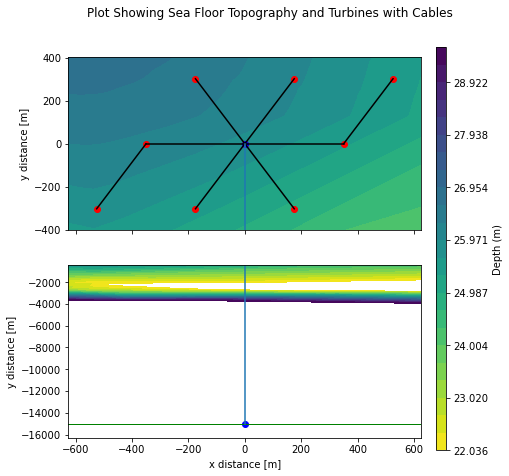

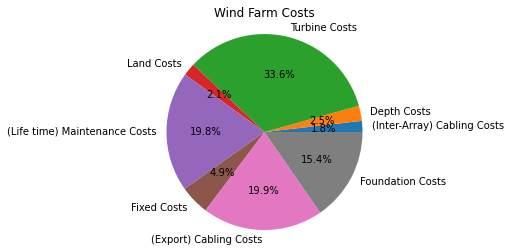

In [59]:
#DISPLAYING PRE-OPTIMISED LAYOUT AND ASSOCIATED INFO

print('\033[1m'+'\033[4m'+'PRE-OPTIMISED LAYOUT INFORMATION'+'\033[0m'+'\033[0m')
print()
MSTweight = Minimum_Spanning_Tree(distance,indiceslist)
TotalCost = plotting_function(positionlist,indiceslist,MSTweight,data,OnshoreSubstation,ExportDistance)

PayBackTime,DiscountedPayBackTime,NPV,ProfIndex = Payback((np.sum(output)),TotalCost,positionlist)

print('\033[1m'+'Total Power Output:'+'\033[0m', np.sum(output), 'W')
print('\033[1m'+'Cost per Watt:'+'\033[0m',TotalCost/np.sum(output),'£/W')
print('')
print('\033[1m'+'Payback Time:'+'\033[0m',PayBackTime,'years')
print('\033[1m'+'Discounted Payback Time:'+'\033[0m',DiscountedPayBackTime,'years')
print('\033[1m'+'NPV: £'+'\033[0m',NPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
print('\033[1m'+'Profitability Index: £'+'\033[0m',ProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [60]:
#REDUCING NO. OF TURBINES PRE-OPTIMISATION

overspend = TotalCost - budget
if overspend > 0:
    nturbstoremove = math.floor(overspend/(MinCostperTurbTot))
    ### It can be safely assumed that this many turbines at minimum can be removed.
    print('Number of removed turbines:', nturbstoremove)
    for amount in range(0,nturbstoremove):
        nturb = nturb - 1
        positionlist = np.delete(positionlist, len(positionlist)-1, 0)
    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree)
    print('new number of turbines:', nturb)

Number of removed turbines: 0
new number of turbines: 8


C:\Users\Matthew Oxley\Documents\python anaconda\lib\site-packages\pulp\pulp.py:1313: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [61]:
#TARGET FUNCTION

# analyses the coordinates to collate the distances and angles between all of them
# calculates the minimum spanning tree length and adds the assumption of cabling costs,
# turbines costs, maintenance costs and fixed costs.

smallestindiceslist = []
smallestTotalCost = None
smallestCostPerWatt = 10000000000000.0
smallestpositionlist = []
smallestExportDistance = None

def targetfunction(coord_flat):
    
    #Global variables are used instead of res.x as res.x only holds the coordinates, not the other associated parameters,
    #inc. the optimal clustering, which will not necessarily be the same if the clustering algorithm is run again as the
    #start position is random for clustering. Additionally, res.x only provides an approximate minimization, whereas
    #storing values as global variables and finding the minimum guarantees that the minimum value found is returned.
    
    global smallestindiceslist
    global smallestTotalCost
    global smallestCostPerWatt
    global smallestpositionlist
    global smallestExportDistance

    positionlist = np.reshape(coord_flat,(-1,2))#np.concatenate((arr1,arr2),axis=0) #np.reshape(coord_flat,(-1,2))
    
    nturb=np.size(positionlist,0)-1 # determines number of turbines (-1 due to the substation)
    print('nturb', nturb)
    
    OnshoreSubstation,ExportDistance = Substation_To_Shore_Connection(positionlist)

    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree) # calls clustering function
    distance,angle,distance_global,angle_global = geom_analysis(positionlist,indiceslist) # calls pre-MST function
    
    MSTweight=Minimum_Spanning_Tree(distance,indiceslist) # Calls MST function
    MSTWeightSum=0
    
    for a in range(0,math.ceil(nturb/maxnodespertree)): 
        MSTWeightSum += MSTweight[a][0] 
        
    wsr=windspeedreduction(distance_global,angle_global,angles,model) # calls wake attenuation function
    powout=power(wsr,velocities) # total output power
    output=np.tensordot(powout,wsp,axes=2) # reduced power output due to wake effects
    
    FoundationCostTotal = foundations(positionlist)
    ExportCableCost = (ExportDistance*ExportCableCostperMeter) # Export cable cost
    FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
    CableCost=(MSTWeightSum/1000)*IACableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal=(nturb)*CostperTurbine
    MaintenanceCosts=(nturb)*MaintenanceCostperTurbine
    LandCost = LandAreaCost(positionlist)
    TotalCost=TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost+ExportCableCost+FoundationCostTotal
    
    print('Total power output in Watts', np.sum(output),'Total Cost in £', TotalCost, '£/W', (TotalCost/(np.sum(output))))###

    CostperWatt = TotalCost/(np.sum(output))
    
    if CostperWatt < smallestCostPerWatt:
        smallestCostPerWatt = CostperWatt
        smallestindiceslist = indiceslist
        smallestTotalCost = TotalCost
        smallestpositionlist = positionlist
        smallestExportDistance = ExportDistance

    print('smallest cost per watt',smallestCostPerWatt)
    
    return CostperWatt

In [62]:
# OPTIMIZATION

#if DistanceToMinTurb > TooCloseShore: # if closest turbine is too close to the shore
 #   for s in range(0,nturb+1): # loops for number of turbines plus the substation
  #      positionlist[s,1] = positionlist[s,1] - (DistanceToMinTurb-TooCloseShore)
        # Shifts entire wind farm up by the difference to achieve the minimum distance required

t1_start = perf_counter() # timer starts

while True:  
    
    flat_coords=positionlist.flatten() # turns 2D coords into single list of data without any more structure.
    dvel=1.5
    dang=5
    velocities=np.arange(Vc,Vf,dvel)
    angles=np.arange(0,360,dang)        
    
    b0 = (OnshoreSubstation[1]+TooCloseShore)
    # b = (Lower bound, Upper bound)
    b1 = (b0,max(data['centered_northing'])) #bounds for y coordinates of substation
    b2 = (min(data['centered_easting']),max(data['centered_easting'])) #bounds for x coordinates
    b3 = ((OnshoreSubstation[1]+((TooCloseShore-2500))),max(data['centered_northing'])) #bounds for y coordinates of turbines
    bnd0 = (b2,b1) #bounds for x,y coordinates of the substation
    bnd = (b2,b3) #bounds for x,y coordinates of each turbine 
    bnd1 = (bnd*(nturb)) #repeats bnd fro the amount of turbines 
    bnds = bnd0+bnd1 #Combines all bounds into a list for use in the optimization function
        
    res = minimize(targetfunction, flat_coords, method='L-BFGS-B', jac=False, bounds=bnds, options={'disp': 2, 'eps': 50})#, 'ftol': 1e-17, 'gtol': 1e-17})
   
    if smallestTotalCost<=budget: #if under budget
        if not res.success:
            print(res.status, res.message) 
        break # Stops optimization when minimization stops being succesful
    else: # over budget then removes a turbine and resets approrate varaibles 
        nturb = nturb - 1 
        smallestindiceslist = []
        smallestTotalCost = None
        smallestCostPerWatt = 10000000000000.0
        smallestpositionlist = []
        smallestExportDistance = None
        positionlist = np.delete(positionlist, len(positionlist)-1, 0) 

        # CANNOT USE CALLBACK as this only returns targetfunction output and not the other variables that are needed too.
        
t1_stop = perf_counter() # timer ends
totaltime = t1_stop - t1_start # total run time in seconds
print('Total function time:', totaltime)

nturb 8
Total power output in Watts 6227412.261859251 Total Cost in £ 52825043.563049465 £/W 8.482663639692623
smallest cost per watt 8.482663639692623
nturb 8
Total power output in Watts 6227412.261859251 Total Cost in £ 52792690.49831961 £/W 8.477468373445678
smallest cost per watt 8.477468373445678
nturb 8
Total power output in Watts 6227412.261859251 Total Cost in £ 52830989.77322306 £/W 8.483618484164701
smallest cost per watt 8.477468373445678
nturb 8
Total power output in Watts 6239671.342030044 Total Cost in £ 52813021.14524494 £/W 8.46407098231275
smallest cost per watt 8.46407098231275
nturb 8
Total power output in Watts 6173156.342907831 Total Cost in £ 52801691.3717179 £/W 8.553434975347791
smallest cost per watt 8.46407098231275
nturb 8
Total power output in Watts 6265828.495146584 Total Cost in £ 52882540.61365045 £/W 8.439832123495316
smallest cost per watt 8.439832123495316
nturb 8
Total power output in Watts 6251904.728556233 Total Cost in £ 52922545.89903526 £/W 8.465

Total power output in Watts 6426194.627371261 Total Cost in £ 53159245.203582935 £/W 8.272274384152691
smallest cost per watt 8.243979660193617
nturb 8
Total power output in Watts 6532782.655949744 Total Cost in £ 53509235.60780405 £/W 8.190879511209578
smallest cost per watt 8.190879511209578
nturb 8
Total power output in Watts 6532782.655949744 Total Cost in £ 53488164.78520257 £/W 8.187654113440942
smallest cost per watt 8.187654113440942
nturb 8
Total power output in Watts 6532782.655949744 Total Cost in £ 53532691.30364538 £/W 8.1944699713667
smallest cost per watt 8.187654113440942
nturb 8
Total power output in Watts 6537284.791798182 Total Cost in £ 53518034.559360325 £/W 8.186584532236564
smallest cost per watt 8.186584532236564
nturb 8
Total power output in Watts 6524759.273019811 Total Cost in £ 53504944.54263621 £/W 8.200294034430005
smallest cost per watt 8.186584532236564
nturb 8
Total power output in Watts 6540486.908172116 Total Cost in £ 53578754.84531974 £/W 8.19186026

Total power output in Watts 6208576.338046927 Total Cost in £ 53843579.70123963 £/W 8.672451906772812
smallest cost per watt 8.155136602157317
nturb 8
Total power output in Watts 6208576.338046927 Total Cost in £ 53841200.922332 £/W 8.67206876275104
smallest cost per watt 8.155136602157317
nturb 8
Total power output in Watts 6208576.338046927 Total Cost in £ 53856653.46464017 £/W 8.67455766543449
smallest cost per watt 8.155136602157317
nturb 8
Total power output in Watts 6209680.141401194 Total Cost in £ 53921654.7100846 £/W 8.68348344556075
smallest cost per watt 8.155136602157317
nturb 8
Total power output in Watts 6203153.2647216 Total Cost in £ 53831016.28728766 £/W 8.678008424108091
smallest cost per watt 8.155136602157317
nturb 8
Total power output in Watts 6209365.347505893 Total Cost in £ 53848648.687625095 £/W 8.672166264021557
smallest cost per watt 8.155136602157317
nturb 8
Total power output in Watts 6211844.256932974 Total Cost in £ 53875947.388406225 £/W 8.67310015512315

Total power output in Watts 6356721.18837048 Total Cost in £ 53963610.08724215 £/W 8.489220855866341
smallest cost per watt 8.146726342722252
nturb 8
Total power output in Watts 6356721.18837048 Total Cost in £ 53978407.03918473 £/W 8.491548620684727
smallest cost per watt 8.146726342722252
nturb 8
Total power output in Watts 6357191.126414484 Total Cost in £ 54044420.36830643 £/W 8.501304946417113
smallest cost per watt 8.146726342722252
nturb 8
Total power output in Watts 6353339.958689148 Total Cost in £ 53952409.729778096 £/W 8.49197588679165
smallest cost per watt 8.146726342722252
nturb 8
Total power output in Watts 6357219.531751565 Total Cost in £ 53968525.58163489 £/W 8.489328599096732
smallest cost per watt 8.146726342722252
nturb 8
Total power output in Watts 6359469.36927951 Total Cost in £ 53997039.13150459 £/W 8.49080890181599
smallest cost per watt 8.146726342722252
nturb 8
Total power output in Watts 6356721.142353756 Total Cost in £ 53967630.913712665 £/W 8.48985344883

Total power output in Watts 6591211.231066761 Total Cost in £ 53773638.74832198 £/W 8.158384986186968
smallest cost per watt 8.146726342722252
nturb 8
Total power output in Watts 6592584.161983075 Total Cost in £ 53823057.80259279 £/W 8.164182129516055
smallest cost per watt 8.146726342722252
nturb 8
Total power output in Watts 6582012.208724675 Total Cost in £ 53734201.14404436 £/W 8.163795423049793
smallest cost per watt 8.146726342722252
nturb 8
Total power output in Watts 6593287.8453285685 Total Cost in £ 53820891.87141324 £/W 8.162982283497003
smallest cost per watt 8.146726342722252
nturb 8
Total power output in Watts 6595402.289037921 Total Cost in £ 53885785.28832807 £/W 8.170204473787823
smallest cost per watt 8.146726342722252
nturb 8
Total power output in Watts 6588790.706210116 Total Cost in £ 53742314.72460142 £/W 8.15662799456474
smallest cost per watt 8.146726342722252
nturb 8
Total power output in Watts 6591967.30753543 Total Cost in £ 53892394.148769416 £/W 8.17546441

Total power output in Watts 6591348.386096673 Total Cost in £ 53753431.56620733 £/W 8.15514951077249
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6591348.386096673 Total Cost in £ 53740356.33583312 £/W 8.15316581493238
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6591348.386096673 Total Cost in £ 53774669.8130358 £/W 8.158371650702655
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6592747.336290026 Total Cost in £ 53822788.566219226 £/W 8.163939223023103
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6582145.926728669 Total Cost in £ 53735240.89103828 £/W 8.163787538169142
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6593424.601256622 Total Cost in £ 53821961.46857636 £/W 8.162975194759728
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6595534.42538275 Total Cost in £ 53887363.89970812 £/W 8.17028013565

Total power output in Watts 6591349.593720455 Total Cost in £ 53753439.617446795 £/W 8.155149238125288
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6591349.593720455 Total Cost in £ 53740363.918700665 £/W 8.153165471590043
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6591349.593720455 Total Cost in £ 53774677.90866886 £/W 8.158371384200244
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6592748.656796417 Total Cost in £ 53822786.46324147 £/W 8.163937268828828
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6582147.189438457 Total Cost in £ 53735249.05451782 £/W 8.16378721228538
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6593425.847209703 Total Cost in £ 53821969.86573365 £/W 8.162974925775616
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6595535.718096819 Total Cost in £ 53887376.286017284 £/W 8.170280

Total power output in Watts 6593734.809111681 Total Cost in £ 53757325.04072129 £/W 8.152788457072262
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6590283.04759755 Total Cost in £ 53752108.71871567 £/W 8.156267087543485
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6591349.749654837 Total Cost in £ 53753440.32597849 £/W 8.155149152689606
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6591349.749654837 Total Cost in £ 53740364.58601464 £/W 8.153165379947986
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6591349.749654837 Total Cost in £ 53774678.62110774 £/W 8.158371299281109
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6592748.888595179 Total Cost in £ 53822786.2781816 £/W 8.163936953717416
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6582147.331289982 Total Cost in £ 53735249.772927135 £/W 8.163787145

Total power output in Watts 6586789.31188337 Total Cost in £ 53740195.76689458 £/W 8.15878468587734
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6569126.023393633 Total Cost in £ 53715764.12903454 £/W 8.177003141322716
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6593734.737572489 Total Cost in £ 53757325.14882589 £/W 8.152788561921566
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6590283.034667725 Total Cost in £ 53752108.823562376 £/W 8.156267119454984
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6591349.7402315745 Total Cost in £ 53753440.20339754 £/W 8.155149145751295
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6591349.7402315745 Total Cost in £ 53740364.47056465 £/W 8.153165374088704
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6591349.7402315745 Total Cost in £ 53774678.49785083 £/W 8.158371

Total power output in Watts 6569126.057221374 Total Cost in £ 53715764.170589946 £/W 8.177003105541072
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6593734.739026937 Total Cost in £ 53757325.324328505 £/W 8.152788586739794
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6590283.023951585 Total Cost in £ 53752108.993775964 £/W 8.156267158545457
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 3597386.52448334 Total Cost in £ 167067756.07636496 £/W 46.44142488979813
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 3597386.52448334 Total Cost in £ 167096506.96673113 £/W 46.44941705026532
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 3597386.52448334 Total Cost in £ 169174299.36892506 £/W 47.02700091234206
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 3597386.524459268 Total Cost in £ 166630014.12992844 £/W 46.319

Total power output in Watts 6615497.906636172 Total Cost in £ 54613104.22392344 £/W 8.255327867179833
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6612983.682621028 Total Cost in £ 54614902.3219998 £/W 8.258738406617907
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6611051.19964922 Total Cost in £ 54554182.838744655 £/W 8.251967983796476
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6618791.094050158 Total Cost in £ 54618218.36270494 £/W 8.251993088557063
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6612810.550925294 Total Cost in £ 54600000.61823646 £/W 8.256701170820111
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6592690.662898022 Total Cost in £ 53891832.300290644 £/W 8.174482173656365
smallest cost per watt 8.146718141399525
nturb 8
Total power output in Watts 6592690.662898022 Total Cost in £ 53881220.59961471 £/W 8.17287255

Total power output in Watts 6587499.253813007 Total Cost in £ 53666148.298836306 £/W 8.146664801179751
smallest cost per watt 8.146664801179751
nturb 8
Total power output in Watts 6588581.320647474 Total Cost in £ 53748661.02765322 £/W 8.15785044030863
smallest cost per watt 8.146664801179751
nturb 8
Total power output in Watts 6587014.426212705 Total Cost in £ 53740991.14500872 £/W 8.158626604968262
smallest cost per watt 8.146664801179751
nturb 8
Total power output in Watts 6568867.873790163 Total Cost in £ 53716518.89631131 £/W 8.177439389615472
smallest cost per watt 8.146664801179751
nturb 8
Total power output in Watts 6593732.5554187205 Total Cost in £ 53758634.7408208 £/W 8.15298987166867
smallest cost per watt 8.146664801179751
nturb 8
Total power output in Watts 6590412.7672416335 Total Cost in £ 53752891.53513033 £/W 8.156225328148633
smallest cost per watt 8.146664801179751
nturb 8
Total power output in Watts 6591360.363955726 Total Cost in £ 53753015.34139127 £/W 8.15507154

Total power output in Watts 6588183.707363661 Total Cost in £ 53759062.30231963 £/W 8.159921564153217
smallest cost per watt 8.146507707717035
nturb 8
Total power output in Watts 6587497.859056104 Total Cost in £ 53665756.74998011 £/W 8.146607087879898
smallest cost per watt 8.146507707717035
nturb 8
Total power output in Watts 6588579.761939168 Total Cost in £ 53748221.426474094 £/W 8.15778564858032
smallest cost per watt 8.146507707717035
nturb 8
Total power output in Watts 6586998.294716129 Total Cost in £ 53740557.14244802 £/W 8.15858069760803
smallest cost per watt 8.146507707717035
nturb 8
Total power output in Watts 6568895.513839545 Total Cost in £ 53716093.78207499 £/W 8.177340265026947
smallest cost per watt 8.146507707717035
nturb 8
Total power output in Watts 6593734.709078099 Total Cost in £ 53758153.26886852 £/W 8.152914189109786
smallest cost per watt 8.146507707717035
nturb 8
Total power output in Watts 6590402.3534283675 Total Cost in £ 53752458.43824798 £/W 8.15617249

Total power output in Watts 6888451.514807295 Total Cost in £ 215253395.68851683 £/W 31.248444621525156
smallest cost per watt 8.146507707717035
nturb 8
Total power output in Watts 6888452.483063596 Total Cost in £ 215289977.59740472 £/W 31.253750842693748
smallest cost per watt 8.146507707717035
nturb 8
Total power output in Watts 6888456.085029595 Total Cost in £ 216066197.5290861 £/W 31.36641866653605
smallest cost per watt 8.146507707717035
nturb 8
Total power output in Watts 6888538.423551844 Total Cost in £ 215293701.91622823 £/W 31.253901579490535
smallest cost per watt 8.146507707717035
nturb 8
Total power output in Watts 6888488.912160381 Total Cost in £ 215341855.78209105 £/W 31.261116701798557
smallest cost per watt 8.146507707717035
nturb 8
Total power output in Watts 6397021.909975441 Total Cost in £ 54655251.38474098 £/W 8.543858713304111
smallest cost per watt 8.146507707717035
nturb 8
Total power output in Watts 6397021.909975441 Total Cost in £ 54662012.65017566 £/W 8.

Total power output in Watts 6586307.552213084 Total Cost in £ 53739654.68256222 £/W 8.15929931248124
smallest cost per watt 8.146507707717035
nturb 8
Total power output in Watts 6585188.570159869 Total Cost in £ 53732358.58151287 £/W 8.159577817557988
smallest cost per watt 8.146507707717035
nturb 8
Total power output in Watts 6564454.031055089 Total Cost in £ 53722810.30698362 £/W 8.183896185856737
smallest cost per watt 8.146507707717035
nturb 8
Total power output in Watts 6591595.743593184 Total Cost in £ 53748562.036775224 £/W 8.154104730863853
smallest cost per watt 8.146507707717035
nturb 8
Total power output in Watts 6588100.414903511 Total Cost in £ 53744276.2478505 £/W 8.157780371147794
smallest cost per watt 8.146507707717035
nturb 8
Total power output in Watts 6591038.341970431 Total Cost in £ 53750765.26061279 £/W 8.155128596102761
smallest cost per watt 8.146507707717035
nturb 8
Total power output in Watts 6591038.341970431 Total Cost in £ 53737855.04997945 £/W 8.153169843

Total power output in Watts 6588298.866053948 Total Cost in £ 53745484.394278266 £/W 8.157718022052793
smallest cost per watt 8.146497888311753
nturb 8
Total power output in Watts 6586751.260977798 Total Cost in £ 53737875.24659532 £/W 8.158479517050713
smallest cost per watt 8.146497888311753
nturb 8
Total power output in Watts 6568380.837345834 Total Cost in £ 53715311.568480015 £/W 8.177861926499594
smallest cost per watt 8.146497888311753
nturb 8
Total power output in Watts 6593498.601182325 Total Cost in £ 53755217.78486639 £/W 8.152760929565858
smallest cost per watt 8.146497888311753
nturb 8
Total power output in Watts 6590119.752366699 Total Cost in £ 53750025.748736665 £/W 8.156153115341114
smallest cost per watt 8.146497888311753
nturb 8
Total power output in Watts 6591278.082916394 Total Cost in £ 53752072.31590971 £/W 8.155030274815296
smallest cost per watt 8.146497888311753
nturb 8
Total power output in Watts 6591278.082916394 Total Cost in £ 53739161.70260816 £/W 8.15307

Total power output in Watts 6587277.781952208 Total Cost in £ 53663363.63806413 £/W 8.146515968263971
smallest cost per watt 8.146490838476518
nturb 8
Total power output in Watts 6588318.155027585 Total Cost in £ 53745541.60590029 £/W 8.157702822060399
smallest cost per watt 8.146490838476518
nturb 8
Total power output in Watts 6586765.069400753 Total Cost in £ 53737929.46499428 £/W 8.15847064511794
smallest cost per watt 8.146490838476518
nturb 8
Total power output in Watts 6568418.881724635 Total Cost in £ 53715239.74103813 £/W 8.177803624931789
smallest cost per watt 8.146490838476518
nturb 8
Total power output in Watts 6593515.218896505 Total Cost in £ 53755282.92349141 £/W 8.152750261261689
smallest cost per watt 8.146490838476518
nturb 8
Total power output in Watts 6590138.84527012 Total Cost in £ 53750063.30242468 £/W 8.156135183859172
smallest cost per watt 8.146490838476518
nturb 8
Total power output in Watts 6591179.941516808 Total Cost in £ 53751236.6675289 £/W 8.15502491882

Total power output in Watts 6417952.0784057565 Total Cost in £ 53858418.50187611 £/W 8.391838680611455
smallest cost per watt 8.146490838476518
nturb 8
Total power output in Watts 6490792.689914717 Total Cost in £ 53767390.05596789 £/W 8.283640015111057
smallest cost per watt 8.146490838476518
nturb 8
Total power output in Watts 6490575.288676301 Total Cost in £ 53864997.52502919 £/W 8.29895581351688
smallest cost per watt 8.146490838476518
nturb 8
Total power output in Watts 6484239.150739417 Total Cost in £ 53864629.74556839 £/W 8.307008500669818
smallest cost per watt 8.146490838476518
nturb 8
Total power output in Watts 6485671.425771734 Total Cost in £ 53855795.56213918 £/W 8.30381189958769
smallest cost per watt 8.146490838476518
nturb 8
Total power output in Watts 6493665.100312173 Total Cost in £ 53870191.21771047 £/W 8.295806818728725
smallest cost per watt 8.146490838476518
nturb 8
Total power output in Watts 6490423.1237432305 Total Cost in £ 53851589.53216504 £/W 8.29708456

Total power output in Watts 6578300.803466365 Total Cost in £ 53745934.23516055 £/W 8.170184952144437
smallest cost per watt 8.145638860726072
nturb 8
Total power output in Watts 6586345.951957927 Total Cost in £ 53652641.033361696 £/W 8.146040524550997
smallest cost per watt 8.145638860726072
nturb 8
Total power output in Watts 6586986.039512798 Total Cost in £ 53740899.654116414 £/W 8.158647875028944
smallest cost per watt 8.145638860726072
nturb 8
Total power output in Watts 6584071.666603103 Total Cost in £ 53733834.81977176 £/W 8.16118619916154
smallest cost per watt 8.145638860726072
nturb 8
Total power output in Watts 6569479.321192699 Total Cost in £ 53732655.4017049 £/W 8.179134566778673
smallest cost per watt 8.145638860726072
nturb 8
Total power output in Watts 6591078.075743586 Total Cost in £ 53746553.75760605 £/W 8.154440463298947
smallest cost per watt 8.145638860726072
nturb 8
Total power output in Watts 6588652.677865731 Total Cost in £ 53742808.86047114 £/W 8.15687386

Total power output in Watts 6588584.539171936 Total Cost in £ 53736637.90250529 £/W 8.156021613294651
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6584833.660302402 Total Cost in £ 53751689.42035239 £/W 8.162953264013641
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6587494.842740696 Total Cost in £ 53658419.55314947 £/W 8.145497011247016
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6588127.347283531 Total Cost in £ 53743058.836234584 £/W 8.157562233279286
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6586290.728288103 Total Cost in £ 53735665.93906844 £/W 8.158714541444986
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6569355.178709369 Total Cost in £ 53722627.43662285 £/W 8.177762653286365
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6593231.137639198 Total Cost in £ 53752022.76513496 £/W 8.1526070

Total power output in Watts 6478345.87898857 Total Cost in £ 66465285.454286106 £/W 10.2596074207546
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6477915.055416544 Total Cost in £ 66821993.07617307 £/W 10.31535494129388
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6477830.934824495 Total Cost in £ 66790054.13483465 £/W 10.310558396295072
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6460318.662350291 Total Cost in £ 66823690.48228496 £/W 10.343714292566215
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6587260.260490223 Total Cost in £ 66844778.71293321 £/W 10.147584286879024
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6478934.240899937 Total Cost in £ 66818689.015474334 £/W 10.313222287959675
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6477891.002742056 Total Cost in £ 66827425.33392661 £/W 10.316

Total power output in Watts 6585658.599872908 Total Cost in £ 53751550.21769835 £/W 8.161909610488413
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6586138.069736993 Total Cost in £ 53658249.42147654 £/W 8.147149187174465
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6586824.490770573 Total Cost in £ 53742805.485547245 £/W 8.15913731432368
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6585734.159142168 Total Cost in £ 53735450.58761749 £/W 8.15937134556565
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6565470.717718712 Total Cost in £ 53728227.696629524 £/W 8.18345401368241
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6591874.516357707 Total Cost in £ 53752259.41763292 £/W 8.154320790580423
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6588974.681652404 Total Cost in £ 53749032.57659507 £/W 8.157419807

Total power output in Watts 6588577.961547725 Total Cost in £ 53736853.9585179 £/W 8.156062548267178
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6585036.434183797 Total Cost in £ 53751937.25239394 £/W 8.162739536771658
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6587511.402770763 Total Cost in £ 53658666.30674259 £/W 8.1455139924575
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6588152.353595739 Total Cost in £ 53743181.16099443 £/W 8.157549837423236
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6586342.524241991 Total Cost in £ 53735777.094148755 £/W 8.158667256731094
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6569316.658668506 Total Cost in £ 53722329.28387446 £/W 8.177765219002719
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6593280.913319479 Total Cost in £ 53752262.43861023 £/W 8.1525818701

Total power output in Watts 6588590.023724681 Total Cost in £ 53736845.19107415 £/W 8.156046285711291
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6585031.359615416 Total Cost in £ 53751940.39327603 £/W 8.162746304129262
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6587518.689195824 Total Cost in £ 53658669.62301388 £/W 8.145505486158141
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6588159.875858321 Total Cost in £ 53743184.2521373 £/W 8.157540992451327
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6586344.717692353 Total Cost in £ 53735779.87317172 £/W 8.158664961587228
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6569339.43899541 Total Cost in £ 53722292.51644962 £/W 8.177731264357515
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6593287.459290434 Total Cost in £ 53752263.1338177 £/W 8.15257388149

Total power output in Watts 6585950.7451796 Total Cost in £ 53729441.94016373 £/W 8.158190672696644
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6596729.1213278 Total Cost in £ 53831043.44127126 £/W 8.160262828926962
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6588590.103564702 Total Cost in £ 53736845.137307 £/W 8.156046178716313
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6585031.364806453 Total Cost in £ 53751940.41257419 £/W 8.162746300625109
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6587518.811023107 Total Cost in £ 53658669.643387586 £/W 8.14550533861077
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6588159.919190608 Total Cost in £ 53743184.27113115 £/W 8.157540941679782
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6586344.789026354 Total Cost in £ 53735779.89025052 £/W 8.15866487581713

Total power output in Watts 6596729.1144380905 Total Cost in £ 53831043.4442888 £/W 8.160262837907075
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6588590.103032797 Total Cost in £ 53736845.13684507 £/W 8.15604617930465
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6585031.361632813 Total Cost in £ 53751940.41273999 £/W 8.162746304584305
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6587518.807222485 Total Cost in £ 53658669.64356264 £/W 8.145505343336835
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6588159.920824008 Total Cost in £ 53743184.27129434 £/W 8.157540939682056
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6586344.786673116 Total Cost in £ 53735779.89039725 £/W 8.158664878754424
smallest cost per watt 8.145488530842728
nturb 8
Total power output in Watts 6569339.565947829 Total Cost in £ 53722292.288947776 £/W 8.17773107

Total power output in Watts 5455662.038094167 Total Cost in £ 47637539.39344166 £/W 8.731761436249622
smallest cost per watt 8.586078506839566
nturb 7
Total power output in Watts 5482755.683459879 Total Cost in £ 47706405.09934865 £/W 8.701172887069745
smallest cost per watt 8.586078506839566
nturb 7
Total power output in Watts 5556117.172369875 Total Cost in £ 47705196.1799291 £/W 8.586067338025773
smallest cost per watt 8.586067338025773
nturb 7
Total power output in Watts 5483934.817608074 Total Cost in £ 47692422.80719845 £/W 8.696752312603241
smallest cost per watt 8.586067338025773
nturb 7
Total power output in Watts 5702688.879027134 Total Cost in £ 47949132.63932451 £/W 8.408162124303812
smallest cost per watt 8.408162124303812
nturb 7
Total power output in Watts 5702688.879027134 Total Cost in £ 47933690.110567436 £/W 8.405454186156621
smallest cost per watt 8.405454186156621
nturb 7
Total power output in Watts 5702688.879027134 Total Cost in £ 47977089.48670932 £/W 8.41306452

Total power output in Watts 5809006.858977026 Total Cost in £ 48269069.040090114 £/W 8.309349637881192
smallest cost per watt 8.309349637881192
nturb 7
Total power output in Watts 5809006.858977026 Total Cost in £ 48318939.24338855 £/W 8.317934617122758
smallest cost per watt 8.309349637881192
nturb 7
Total power output in Watts 5811087.537027348 Total Cost in £ 48287418.56092242 £/W 8.309532123417947
smallest cost per watt 8.309349637881192
nturb 7
Total power output in Watts 5808525.659861407 Total Cost in £ 48270517.05676077 £/W 8.310287305834596
smallest cost per watt 8.309349637881192
nturb 7
Total power output in Watts 5811291.572418138 Total Cost in £ 48357743.47550938 £/W 8.321341800337034
smallest cost per watt 8.309349637881192
nturb 7
Total power output in Watts 5810072.735467995 Total Cost in £ 48384350.94451999 £/W 8.32766699273046
smallest cost per watt 8.309349637881192
nturb 7
Total power output in Watts 5806189.887056426 Total Cost in £ 48256260.639720455 £/W 8.3111750

Total power output in Watts 5815551.438046193 Total Cost in £ 48321079.66072339 £/W 8.308942011001704
smallest cost per watt 8.283311171629984
nturb 7
Total power output in Watts 5816455.183629473 Total Cost in £ 48428520.926760495 £/W 8.32612293877266
smallest cost per watt 8.283311171629984
nturb 7
Total power output in Watts 5815585.282822128 Total Cost in £ 48225235.28808043 £/W 8.292413049212165
smallest cost per watt 8.283311171629984
nturb 7
Total power output in Watts 5816259.3976120865 Total Cost in £ 48325264.997921355 £/W 8.308650232787365
smallest cost per watt 8.283311171629984
nturb 7
Total power output in Watts 5818062.121694557 Total Cost in £ 48315832.392636955 £/W 8.304454538647068
smallest cost per watt 8.283311171629984
nturb 7
Total power output in Watts 5817603.939839207 Total Cost in £ 48334376.39582593 £/W 8.308296146602556
smallest cost per watt 8.283311171629984
nturb 7
Total power output in Watts 5808682.523974938 Total Cost in £ 48305714.56789115 £/W 8.31612

Total power output in Watts 5808456.832007764 Total Cost in £ 48150861.44594538 £/W 8.289785538321967
smallest cost per watt 8.283280724615578
nturb 7
Total power output in Watts 5809361.131086856 Total Cost in £ 48148907.28416236 £/W 8.288158748904344
smallest cost per watt 8.283280724615578
nturb 7
Total power output in Watts 5795999.239737264 Total Cost in £ 48134054.41138756 £/W 8.30470336872741
smallest cost per watt 8.283280724615578
nturb 7
Total power output in Watts 5793264.426461222 Total Cost in £ 48118238.121222965 £/W 8.305893634241668
smallest cost per watt 8.283280724615578
nturb 7
Total power output in Watts 5786209.322297666 Total Cost in £ 48132383.64341545 £/W 8.318465676299176
smallest cost per watt 8.283280724615578
nturb 7
Total power output in Watts 5794669.860723405 Total Cost in £ 48131379.59671101 £/W 8.30614698568907
smallest cost per watt 8.283280724615578
nturb 7
Total power output in Watts 5805067.203657647 Total Cost in £ 48144588.80106306 £/W 8.293545468

Total power output in Watts 5805041.344449123 Total Cost in £ 48131015.69627759 £/W 8.291244254840883
smallest cost per watt 8.283280724615578
nturb 7
Total power output in Watts 5805041.344449123 Total Cost in £ 48166062.09662396 £/W 8.297281490110512
smallest cost per watt 8.283280724615578
nturb 7
Total power output in Watts 5815182.200322635 Total Cost in £ 48168963.15453124 £/W 8.28331108040927
smallest cost per watt 8.283280724615578
nturb 7
Total power output in Watts 5811848.401730213 Total Cost in £ 48145673.11477098 £/W 8.284055224227425
smallest cost per watt 8.283280724615578
nturb 7
Total power output in Watts 5805883.359528606 Total Cost in £ 48225105.65878281 £/W 8.306247761528976
smallest cost per watt 8.283280724615578
nturb 7
Total power output in Watts 5805866.536146633 Total Cost in £ 48261122.792660445 £/W 8.312475406072883
smallest cost per watt 8.283280724615578
nturb 7
Total power output in Watts 5804873.160915549 Total Cost in £ 48133855.25813624 £/W 8.29197364

Total power output in Watts 5805883.38159488 Total Cost in £ 48225105.89507961 £/W 8.306247770659173
smallest cost per watt 8.283280724615578
nturb 7
Total power output in Watts 5805866.544453682 Total Cost in £ 48261123.04905625 £/W 8.312475438340876
smallest cost per watt 8.283280724615578
nturb 7
Total power output in Watts 5804873.315691071 Total Cost in £ 48133855.48160234 £/W 8.291973461590006
smallest cost per watt 8.283280724615578
nturb 7
Total power output in Watts 5805386.468373119 Total Cost in £ 48236974.148804225 £/W 8.309003097656301
smallest cost per watt 8.283280724615578
nturb 7
Total power output in Watts 5804201.199108102 Total Cost in £ 48135569.93233611 £/W 8.29322903894731
smallest cost per watt 8.283280724615578
nturb 7
Total power output in Watts 5805336.137006429 Total Cost in £ 48171803.06983225 £/W 8.29784907074691
smallest cost per watt 8.283280724615578
nturb 7
Total power output in Watts 5808326.978891498 Total Cost in £ 48149524.601872936 £/W 8.289740707

Total power output in Watts 5823238.678601587 Total Cost in £ 48194458.56469512 £/W 8.276229298619219
smallest cost per watt 8.276229298619219
nturb 7
Total power output in Watts 5824162.51008515 Total Cost in £ 48319967.465901405 £/W 8.296466209902334
smallest cost per watt 8.276229298619219
nturb 7
Total power output in Watts 5824776.208823587 Total Cost in £ 48285943.48318343 £/W 8.289750842279243
smallest cost per watt 8.276229298619219
nturb 7
Total power output in Watts 5825109.905950833 Total Cost in £ 48309125.911037505 £/W 8.29325569663256
smallest cost per watt 8.276229298619219
nturb 7
Total power output in Watts 5818021.987057006 Total Cost in £ 48275719.98936116 £/W 8.297617316805809
smallest cost per watt 8.276229298619219
nturb 7
Total power output in Watts 5818519.050538587 Total Cost in £ 48280499.49692948 £/W 8.297729899579933
smallest cost per watt 8.276229298619219
nturb 7
Total power output in Watts 5815043.549049993 Total Cost in £ 48285476.06010991 £/W 8.30354504

nturb 7
Total power output in Watts 5819312.885029049 Total Cost in £ 48233297.161186755 £/W 8.288486650249256
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5807370.279854526 Total Cost in £ 48237041.71666932 £/W 8.306176357309466
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5812715.026133682 Total Cost in £ 48206599.95219134 £/W 8.293301793646657
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5823363.407089656 Total Cost in £ 48251509.95148563 £/W 8.285849015148498
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5823363.407089656 Total Cost in £ 48237616.22456412 £/W 8.283463155645965
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5823363.407089656 Total Cost in £ 48281020.049386196 £/W 8.29091655015149
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5830130.5637038 Total Cost in £ 48350472.05411165 £/W 8.2

Total power output in Watts 5816273.875931261 Total Cost in £ 48456915.96481025 £/W 8.331264482804581
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5799697.770039251 Total Cost in £ 48447749.7113217 £/W 8.353495584131759
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5800195.306902261 Total Cost in £ 48498069.89205884 £/W 8.361454627975354
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5800622.028000044 Total Cost in £ 48469696.11042942 £/W 8.355948013241083
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5800223.655546928 Total Cost in £ 48501657.75476228 £/W 8.362032334456394
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5796401.4349131305 Total Cost in £ 48359139.44680785 £/W 8.342958987541655
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5799207.029485072 Total Cost in £ 48599117.24272973 £/W 8.38030389

Total power output in Watts 5824444.922545769 Total Cost in £ 48333772.15625542 £/W 8.298434065220677
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5824196.779763153 Total Cost in £ 48251636.30962008 £/W 8.284685104953182
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5824424.9668249395 Total Cost in £ 48264941.40079141 £/W 8.286644892105462
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5820899.973738099 Total Cost in £ 48241210.195783585 £/W 8.287586183138577
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5821470.9815871585 Total Cost in £ 48247933.76589328 £/W 8.28792824330785
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5811657.422327633 Total Cost in £ 48252108.0014492 £/W 8.3026414833178
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5815966.729606591 Total Cost in £ 48214315.5019432 £/W 8.2899916288

Total power output in Watts 5821518.4483428085 Total Cost in £ 48247279.18908458 £/W 8.287748225348142
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5811898.272948267 Total Cost in £ 48251480.676644385 £/W 8.302189475895165
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5816174.519833368 Total Cost in £ 48213948.23097299 £/W 8.289632311850626
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5824089.601502856 Total Cost in £ 48254088.02537921 £/W 8.28525852571493
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5824089.601502856 Total Cost in £ 48240584.764448 £/W 8.282940006966914
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5824089.601502856 Total Cost in £ 48280318.343636796 £/W 8.289762288543514
smallest cost per watt 8.269911594980245
nturb 7
Total power output in Watts 5830489.999155467 Total Cost in £ 48353262.060020484 £/W 8.2931729

Total power output in Watts 5824089.886059098 Total Cost in £ 48240585.06367439 £/W 8.282939653652331
smallest cost per watt 8.26991150964145
nturb 7
Total power output in Watts 5824089.886059098 Total Cost in £ 48280317.498094454 £/W 8.289761738338072
smallest cost per watt 8.26991150964145
nturb 7
Total power output in Watts 5830490.091126664 Total Cost in £ 48353261.3360707 £/W 8.293172714530261
smallest cost per watt 8.26991150964145
nturb 7
Total power output in Watts 5828130.181189489 Total Cost in £ 48253064.58267871 £/W 8.279338841540861
smallest cost per watt 8.26991150964145
nturb 7
Total power output in Watts 5824399.33499847 Total Cost in £ 48292805.69890733 £/W 8.29146542351908
smallest cost per watt 8.26991150964145
nturb 7
Total power output in Watts 5825085.538085103 Total Cost in £ 48384663.424429506 £/W 8.306258012536436
smallest cost per watt 8.26991150964145
nturb 7
Total power output in Watts 5823793.541422651 Total Cost in £ 48255219.22483021 £/W 8.285873955113166

Total power output in Watts 5819586.269998711 Total Cost in £ 48757168.66111771 £/W 8.378115968908647
smallest cost per watt 8.26991150964145
nturb 7
Total power output in Watts 5819278.924867819 Total Cost in £ 48787083.09556644 £/W 8.383699033067847
smallest cost per watt 8.26991150964145
nturb 7
Total power output in Watts 5819870.141673875 Total Cost in £ 48780011.10380188 £/W 8.38163222139731
smallest cost per watt 8.26991150964145
nturb 7
Total power output in Watts 5818643.7890015 Total Cost in £ 48786002.87413441 £/W 8.384428510016464
smallest cost per watt 8.26991150964145
nturb 7
Total power output in Watts 5814021.0267981775 Total Cost in £ 48668288.02163005 £/W 8.370848298846283
smallest cost per watt 8.26991150964145
nturb 7
Total power output in Watts 5820074.773236544 Total Cost in £ 48928454.89644901 £/W 8.406843005083918
smallest cost per watt 8.26991150964145
nturb 7
Total power output in Watts 5815976.417501279 Total Cost in £ 48788287.27570117 £/W 8.38866662679181
s

Total power output in Watts 5823620.678686304 Total Cost in £ 48145315.0462229 £/W 8.267247766055318
smallest cost per watt 8.265239454317705
nturb 7
Total power output in Watts 5824667.044173067 Total Cost in £ 48361149.89618559 £/W 8.302817917217354
smallest cost per watt 8.265239454317705
nturb 7
Total power output in Watts 5823042.768631569 Total Cost in £ 48241956.78274093 £/W 8.284664684693347
smallest cost per watt 8.265239454317705
nturb 7
Total power output in Watts 5823512.683642245 Total Cost in £ 48249009.92373976 £/W 8.285207321565068
smallest cost per watt 8.265239454317705
nturb 7
Total power output in Watts 5823224.9578590635 Total Cost in £ 48226516.78304345 £/W 8.281754033554314
smallest cost per watt 8.265239454317705
nturb 7
Total power output in Watts 5823192.227046221 Total Cost in £ 48235281.36360817 £/W 8.283305699505513
smallest cost per watt 8.265239454317705
nturb 7
Total power output in Watts 5812037.7271764465 Total Cost in £ 48238113.92546497 £/W 8.2996904

Total power output in Watts 5787258.051550185 Total Cost in £ 48056425.412907645 £/W 8.303833177101057
smallest cost per watt 8.24842956838599
nturb 7
Total power output in Watts 5787478.264123898 Total Cost in £ 48049253.80460181 £/W 8.30227805820977
smallest cost per watt 8.24842956838599
nturb 7
Total power output in Watts 5794979.437813472 Total Cost in £ 48064970.256277695 £/W 8.294243451951452
smallest cost per watt 8.24842956838599
nturb 7
Total power output in Watts 5768634.991040029 Total Cost in £ 47988791.955043584 £/W 8.318916351889284
smallest cost per watt 8.24842956838599
nturb 7
Total power output in Watts 5806283.964746768 Total Cost in £ 47998609.96876183 £/W 8.266665953678555
smallest cost per watt 8.24842956838599
nturb 7
Total power output in Watts 5806283.964746768 Total Cost in £ 48086342.73993477 £/W 8.28177592275785
smallest cost per watt 8.24842956838599
nturb 7
Total power output in Watts 5806283.964746768 Total Cost in £ 48033796.688932866 £/W 8.272726063791

Total power output in Watts 5808949.651091109 Total Cost in £ 48074490.589995265 £/W 8.275935147925635
smallest cost per watt 8.24842956838599
nturb 7
Total power output in Watts 5808949.651091109 Total Cost in £ 48023077.71047574 £/W 8.267084515262662
smallest cost per watt 8.24842956838599
nturb 7
Total power output in Watts 5811651.132929398 Total Cost in £ 47998677.65625358 £/W 8.259043180394682
smallest cost per watt 8.24842956838599
nturb 7
Total power output in Watts 5810611.84110604 Total Cost in £ 47983050.331928186 £/W 8.25783095550824
smallest cost per watt 8.24842956838599
nturb 7
Total power output in Watts 5810072.458609111 Total Cost in £ 47983287.38425008 £/W 8.258638377762493
smallest cost per watt 8.24842956838599
nturb 7
Total power output in Watts 5809932.236412488 Total Cost in £ 48114643.77640657 £/W 8.281446636306443
smallest cost per watt 8.24842956838599
nturb 7
Total power output in Watts 5818966.999976717 Total Cost in £ 47997442.73245361 £/W 8.24844731593179

Total power output in Watts 5810084.522590886 Total Cost in £ 47983244.752719365 £/W 8.258613892130134
smallest cost per watt 8.24842956838599
nturb 7
Total power output in Watts 5809945.0687351525 Total Cost in £ 48114600.15690821 £/W 8.281420837492176
smallest cost per watt 8.24842956838599
nturb 7
Total power output in Watts 5818974.220905062 Total Cost in £ 47997399.30258606 £/W 8.248429616710128
smallest cost per watt 8.24842956838599
nturb 7
Total power output in Watts 5813835.717462385 Total Cost in £ 48142365.0010436 £/W 8.280654518056577
smallest cost per watt 8.24842956838599
nturb 7
Total power output in Watts 5787591.334052967 Total Cost in £ 47896196.62505411 £/W 8.275670112235291
smallest cost per watt 8.24842956838599
nturb 7
Total power output in Watts 5805804.40011447 Total Cost in £ 47988511.32554811 £/W 8.265609383017097
smallest cost per watt 8.24842956838599
nturb 7
Total power output in Watts 5798715.306170857 Total Cost in £ 47998428.6187272 £/W 8.277424581898062

Total power output in Watts 5787591.376485204 Total Cost in £ 47896196.43691425 £/W 8.27567001905403
smallest cost per watt 8.248429567638281
nturb 7
Total power output in Watts 5805804.397384674 Total Cost in £ 47988511.14717175 £/W 8.265609356179656
smallest cost per watt 8.248429567638281
nturb 7
Total power output in Watts 5798715.329989885 Total Cost in £ 47998428.424090706 £/W 8.27742451433194
smallest cost per watt 8.248429567638281
nturb 7
Total power output in Watts 5814307.878575932 Total Cost in £ 47996787.06638942 £/W 8.254944194345796
smallest cost per watt 8.248429567638281
nturb 7
Total power output in Watts 5808289.880489726 Total Cost in £ 47971895.471802376 £/W 8.259211654181012
smallest cost per watt 8.248429567638281
nturb 7
Total power output in Watts 5808190.043235305 Total Cost in £ 47983950.77207355 £/W 8.261429191346727
smallest cost per watt 8.248429567638281
nturb 7
Total power output in Watts 5810158.940547333 Total Cost in £ 47983392.482577674 £/W 8.2585335

Total power output in Watts 5808289.880891124 Total Cost in £ 47971895.468108535 £/W 8.259211652974276
smallest cost per watt 8.248429567300265
nturb 7
Total power output in Watts 5808190.045360182 Total Cost in £ 47983950.76832707 £/W 8.261429187679317
smallest cost per watt 8.248429567300265
nturb 7
Total power output in Watts 5810158.94452977 Total Cost in £ 47983392.478878506 £/W 8.25853353358854
smallest cost per watt 8.248429567300265
nturb 7
Total power output in Watts 5796707.6497219 Total Cost in £ 47922312.48046293 £/W 8.267160494589033
smallest cost per watt 8.248429567300265
Total function time: 138.2697051


In [63]:
#DEFINES OPTIMAL LAYOUT USING DATA TAKEN FROM OPTIMISATION
distance,angle,distance_global,angle_global = geom_analysis(smallestpositionlist,smallestindiceslist)
MSTweight = Minimum_Spanning_Tree(distance,smallestindiceslist)
wsr=windspeedreduction(distance_global,angle_global,angles,model)
powout=power(wsr,velocities) # total output power
output=np.tensordot(powout,wsp,axes=2)

POST-OPTIMISED LAYOUT INFORMATION

Maximum turbines per MST: 10
Number of turbines: 7

Inter-Array Cabling Costs: £ 1136424.0634147583
Export Cabling Costs: £ 9901238.238860263
Depth Cost: £ 872797.2908569733
Foundations Cost: £ 6865801.925177932
Turbine Cost: £ 15544041.450777201
Land Cost: £ 2257096.153449325
Maintenance Cost: £ 9170000
Fixed Cost: 2250000.0

Budget: £ 50000000
Total Cost: £ 47997399.12253646
Total Power Output: 5818974.233933617 W
Cost per Watt 8.248429567300265 £/W

Payback Time: 6.974554736341282 years
Discounted Payback Time: 9.900554707721374 years
NPV: £ 24908348.882047646 over a  20 year period
Profitability Index: £ 1.5189520544323059 over a  20 year period


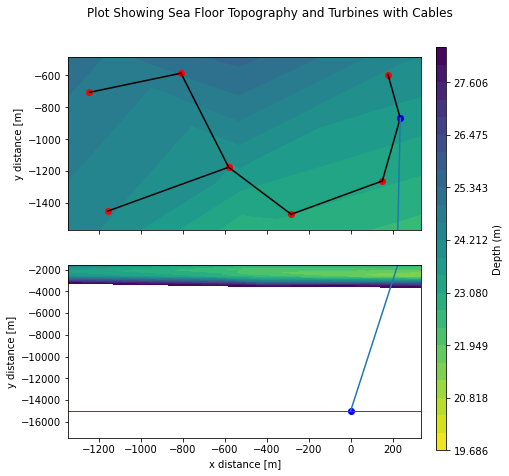

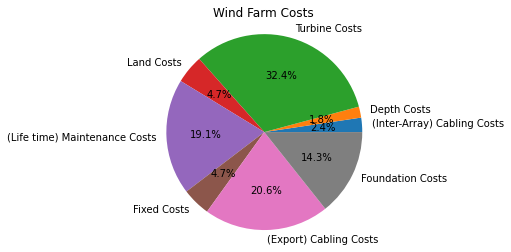

In [64]:
#DISPLAYS OPTIMAL LAYOUT

print('\033[1m'+'\033[4m'+'POST-OPTIMISED LAYOUT INFORMATION'+'\033[0m'+'\033[0m')
print()
OptimizedTPO = smallestTotalCost/smallestCostPerWatt
plotting_function(smallestpositionlist,smallestindiceslist,MSTweight,data,OnshoreSubstation,smallestExportDistance)
OptimizedPayBackTime,OptimizedDiscountedPayBackTime,OptimizedNPV,OptimizedProfIndex = Payback(OptimizedTPO,smallestTotalCost,smallestpositionlist)

print('\033[1m'+'Total Power Output:'+'\033[0m', OptimizedTPO, 'W')
print('\033[1m'+'Cost per Watt'+'\033[0m',smallestCostPerWatt,'£/W')
print('')
print('\033[1m'+'Payback Time:'+'\033[0m',OptimizedPayBackTime,'years')
print('\033[1m'+'Discounted Payback Time:'+'\033[0m',OptimizedDiscountedPayBackTime,'years')
print('\033[1m'+'NPV: £'+'\033[0m',OptimizedNPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
print('\033[1m'+'Profitability Index: £'+'\033[0m',OptimizedProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [65]:
# 8 turbines produce 6MW of output, which is 37.5% of their max output, which is roughly correct.
# If the wind speed decreases by half, power production decreases by a factor of eight.
# On average, therefore, wind turbines do not generate near their capacity.
# Industry estimates project an annual output of 30-40%, but real-world experience shows that
# annual outputs of 15-30% of capacity are more typical in a year. Therefore this improved 37.5% is good.

In [66]:
print(res.success) # whether the minization was succesful or not
print(res.status) # termination status
print(res.message) # Description of the cause of termination
print(res.nit) # number of iterations performed by the optimizer

True
0
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
13
